# Energies and logits

Results referenced in 25b_Section_2_research.ipynb.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json

from scipy.stats import pearsonr, spearmanr

import torch
import torch.nn as nn
import torch.nn.functional as F

import logomaker

from NegativeClassOptimization import ml, visualisations
from NegativeClassOptimization import config, utils
from NegativeClassOptimization import preprocessing, datasets

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [2]:
fp = "../data/Frozen_MiniAbsolut_ML/high_vs_looser/seed_0/split_42/HR2P_high__vs__HR2P_looser/attributions/v2.0-2/attribution_records.json"
fp_test_1 = "../data/MiniAbsolut/HR2P/high_test_500.tsv"
fp_test_2 = "../data/MiniAbsolut/HR2P/looserX_test_500.tsv"

df_test_1 = pd.read_csv(fp_test_1, sep="\t")
df_test_1["class"] = "positive"
df_test_2 = pd.read_csv(fp_test_2, sep="\t")
df_test_2["class"] = "negative"
df_test = pd.concat([df_test_1, df_test_2], axis=0)

with open(fp, "r") as f:
    data = json.load(f)

In [3]:
df_test

Unnamed: 0  ID_slide_Variant                   CDR3  Best  \
0         11803               NaN  HDVGNCDSRNCAKWPEYFQHW  True   
1         11114               NaN  HDVGHCDSDNCAWWPEYFQHW  True   
2          4027               NaN  HDVAFCDTPECAKWPEYFQHW  True   
3         19589               NaN  HDVGYCSSTRCLTWPEYFNLW  True   
4         20388               NaN  HDVQFCSSSRCLTWPEYFQHW  True   
..          ...               ...                    ...   ...   
495        7010               NaN  HDVAYCSDSRCLTWSEYFQHW  True   
496       18512               NaN  HDVGYCSSRRCLTWPEYFQMW  True   
497       15769               NaN  HDVGQCQSSRCAKWPEYFMHW  True   
498       18011               NaN  HDVGYCKSSRCLTWGEYFQHW  True   
499        4198               NaN  HDVAICDTPTCAKWPEYFAHW  True   

                     Slide  Energy  Structure     Source Antigen     class  
0    HDVGNCDSRNCAKWPEYFQHW     NaN        NaN  HR2P_high    HR2P  positive  
1    HDVGHCDSDNCAWWPEYFQHW     NaN        NaN  HR2P_high    HR2P  positive  
2    HDVAFCDTPECAKWPEYFQHW     NaN        NaN  HR2P_high    HR2P  positive  
3    HDVGYCSSTRCLTWPEYFNLW     NaN        NaN  HR2P_high    HR2P  positive  
4    HDVQFCSSSRCLTWPEYFQHW     NaN        NaN  HR2P_high    HR2P  positive  
..                     ...     ...        ...        ...     ...       ...  
495  HDVAYCSDSRCLTWSEYFQHW     NaN        NaN  HR2P_weak    HR2P  negative  
496  HDVGYCSSRRCLTWPEYFQMW     NaN        NaN  HR2P_weak    HR2P  negative  
497  HDVGQCQSSRCAKWPEYFMHW     NaN        NaN  HR2P_weak    HR2P  negative  
498  HDVGYCKSSRCLTWGEYFQHW     NaN        NaN  HR2P_weak    HR2P  negative  
499  HDVAICDTPTCAKWPEYFAHW     NaN        NaN  HR2P_weak    HR2P  negative  

[1000 rows x 10 columns]

In [5]:
df_kd = pd.read_csv("01b_df_kd.csv")
df_kd.head()

Unnamed: 0                   cdr3        Kd_est      E_est      F_min  \
0           0  ADVAYCCTPTCAKWPEYFQWW  2.566097e-07 -36.989043  94.461716   
1           1  CDGACCDTPTCAKWPEYFQHW  3.757516e-07 -36.059492  93.957440   
2           2  CDPAYYSSSRCLTWPEYFQHW  3.962092e-07 -35.930277  94.155020   
3           3  CDRAYCDTPTCAKWPEYFQHW  4.037524e-07 -35.884309  96.954380   
4           4  CDRAYCDTPTCAKWPEYFQPW  3.318797e-07 -36.362107  91.821106   

       F_max  intensity 0  intensity 1  intensity 10  intensity 11  ...  \
0  141.05211   111.342196   108.361792    117.222275    117.295862  ...   
1  144.95908   110.953692   108.887190    113.325916    114.728697  ...   
2  149.19969   109.530200   110.394295    112.850615    111.254278  ...   
3  133.01643   109.273767   110.639957    117.067877    112.947864  ...   
4  142.25514   110.699016   109.528347    112.976801    112.402118  ...   

   intensity 13  intensity 2  intensity 3  intensity 4  intensity 5  \
0    115.080183   107.364475   113.558279   110.967933   111.959556   
1    111.254123   112.172095   111.951280   113.303819   113.053718   
2    111.730989   109.994383   110.328671   110.611589   113.414645   
3    111.826705   109.797395   107.939179   111.938496   113.410432   
4    110.787918   110.135047   109.945588   111.109728   112.412832   

   intensity 6  intensity 7  intensity 8  intensity 9  affinity_est  
0   119.406109   126.040790   118.581446   118.161568  3.896969e+06  
1   113.291626   117.351588   113.952191   113.828101  2.661333e+06  
2   113.032409   117.512647   114.270451   112.941200  2.523919e+06  
3   116.078040   116.459165   113.967739   114.493203  2.476765e+06  
4   114.181798   116.347380   113.271742   114.328324  3.013140e+06  

[5 rows x 21 columns]

In [6]:
df = pd.DataFrame.from_records(data)
df = pd.merge(df, df_test, left_on="slide", right_on="Slide")

df = pd.merge(df, df_kd, left_on="slide", right_on="cdr3", how="left")

df.head()

slide    logits    expits  y_pred  y_true  is_pred_correct  \
0  HDTGYCDSSRCLTWPEYFQHW  9.470077  0.999923       1       1             True   
1  HDTGWCDDSNCAKWPEYFQHW  8.520284  0.999801       1       1             True   
2  HDTAYCDTPRCAKWPEYFQHW  8.360267  0.999766       1       1             True   
3  HDVGYCDTPTCASWPEYFQHW  8.337541  0.999761       1       1             True   
4  HDVGFCDTPTCAKWPEYFQHW  7.975132  0.999656       1       1             True   

                               DeepLIFT_LOCAL_v2.0-2  \
0  [[0.0, 0.00075069087324664, 0.0018600795883685...   
1  [[-0.011101613752543926, -0.002190264407545328...   
2  [[0.0, 0.0, 0.0, 0.0, -0.03196832537651062, 0....   
3  [[0.0, 0.0, 0.0003540836332831532, 0.0, -0.016...   
4  [[-0.011828131973743439, 0.0006424520397558808...   

                          DeepLIFT_GLOBAL_R10_v2.0-2   exec_time  \
0  [[0.1029399037361145, -0.0008842707611620426, ...  191.271252   
1  [[0.1096981018781662, 0.011974796652793884, -0...  191.271252   
2  [[0.12173209339380264, -0.007481561042368412, ...  191.271252   
3  [[0.10983041673898697, -0.015131634660065174, ...  191.271252   
4  [[0.11491819471120834, -0.012472284026443958, ...  191.271252   

   Unnamed: 0_x  ...  intensity 13 intensity 2  intensity 3 intensity 4  \
0          3762  ...    158.505343  120.648466   118.161326  130.462741   
1          3758  ...    144.660103  112.542651   117.557295  124.954847   
2          3680  ...    148.922477  111.104172   113.197650  121.630337   
3         17654  ...    150.979431  116.154006   122.793758  135.698840   
4         11002  ...    150.865414  112.160130   117.758093  127.454716   

   intensity 5  intensity 6 intensity 7 intensity 8 intensity 9  affinity_est  
0   158.765007   209.476718  208.598083  214.569535  187.383495  2.466009e+07  
1   145.895140   175.085066  208.002342  187.880012  179.893261  6.870290e+06  
2   137.500582   170.312209  200.195138  190.295336  177.730149  9.866161e+06  
3   160.892841   192.324927  203.721256  191.848364  182.036794  9.687003e+06  
4   149.616884   179.069848  200.615099  189.036348  181.414487  7.574416e+06  

[5 rows x 40 columns]

In [12]:
df.columns

Index(['slide', 'logits', 'expits', 'y_pred', 'y_true', 'is_pred_correct',
       'DeepLIFT_LOCAL_v2.0-2', 'DeepLIFT_GLOBAL_R10_v2.0-2', 'exec_time',
       'Unnamed: 0_x', 'ID_slide_Variant', 'CDR3', 'Best', 'Slide', 'Energy',
       'Structure', 'Source', 'Antigen', 'class', 'Unnamed: 0_y', 'cdr3',
       'Kd_est', 'E_est', 'F_min', 'F_max', 'intensity 0', 'intensity 1',
       'intensity 10', 'intensity 11', 'intensity 12', 'intensity 13',
       'intensity 2', 'intensity 3', 'intensity 4', 'intensity 5',
       'intensity 6', 'intensity 7', 'intensity 8', 'intensity 9',
       'affinity_est'],
      dtype='object')

/tmp/ipykernel_284453/1061030710.py:13: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(


Text(200, -10, 'r = 0.84\n$r^2$ = 0.70')

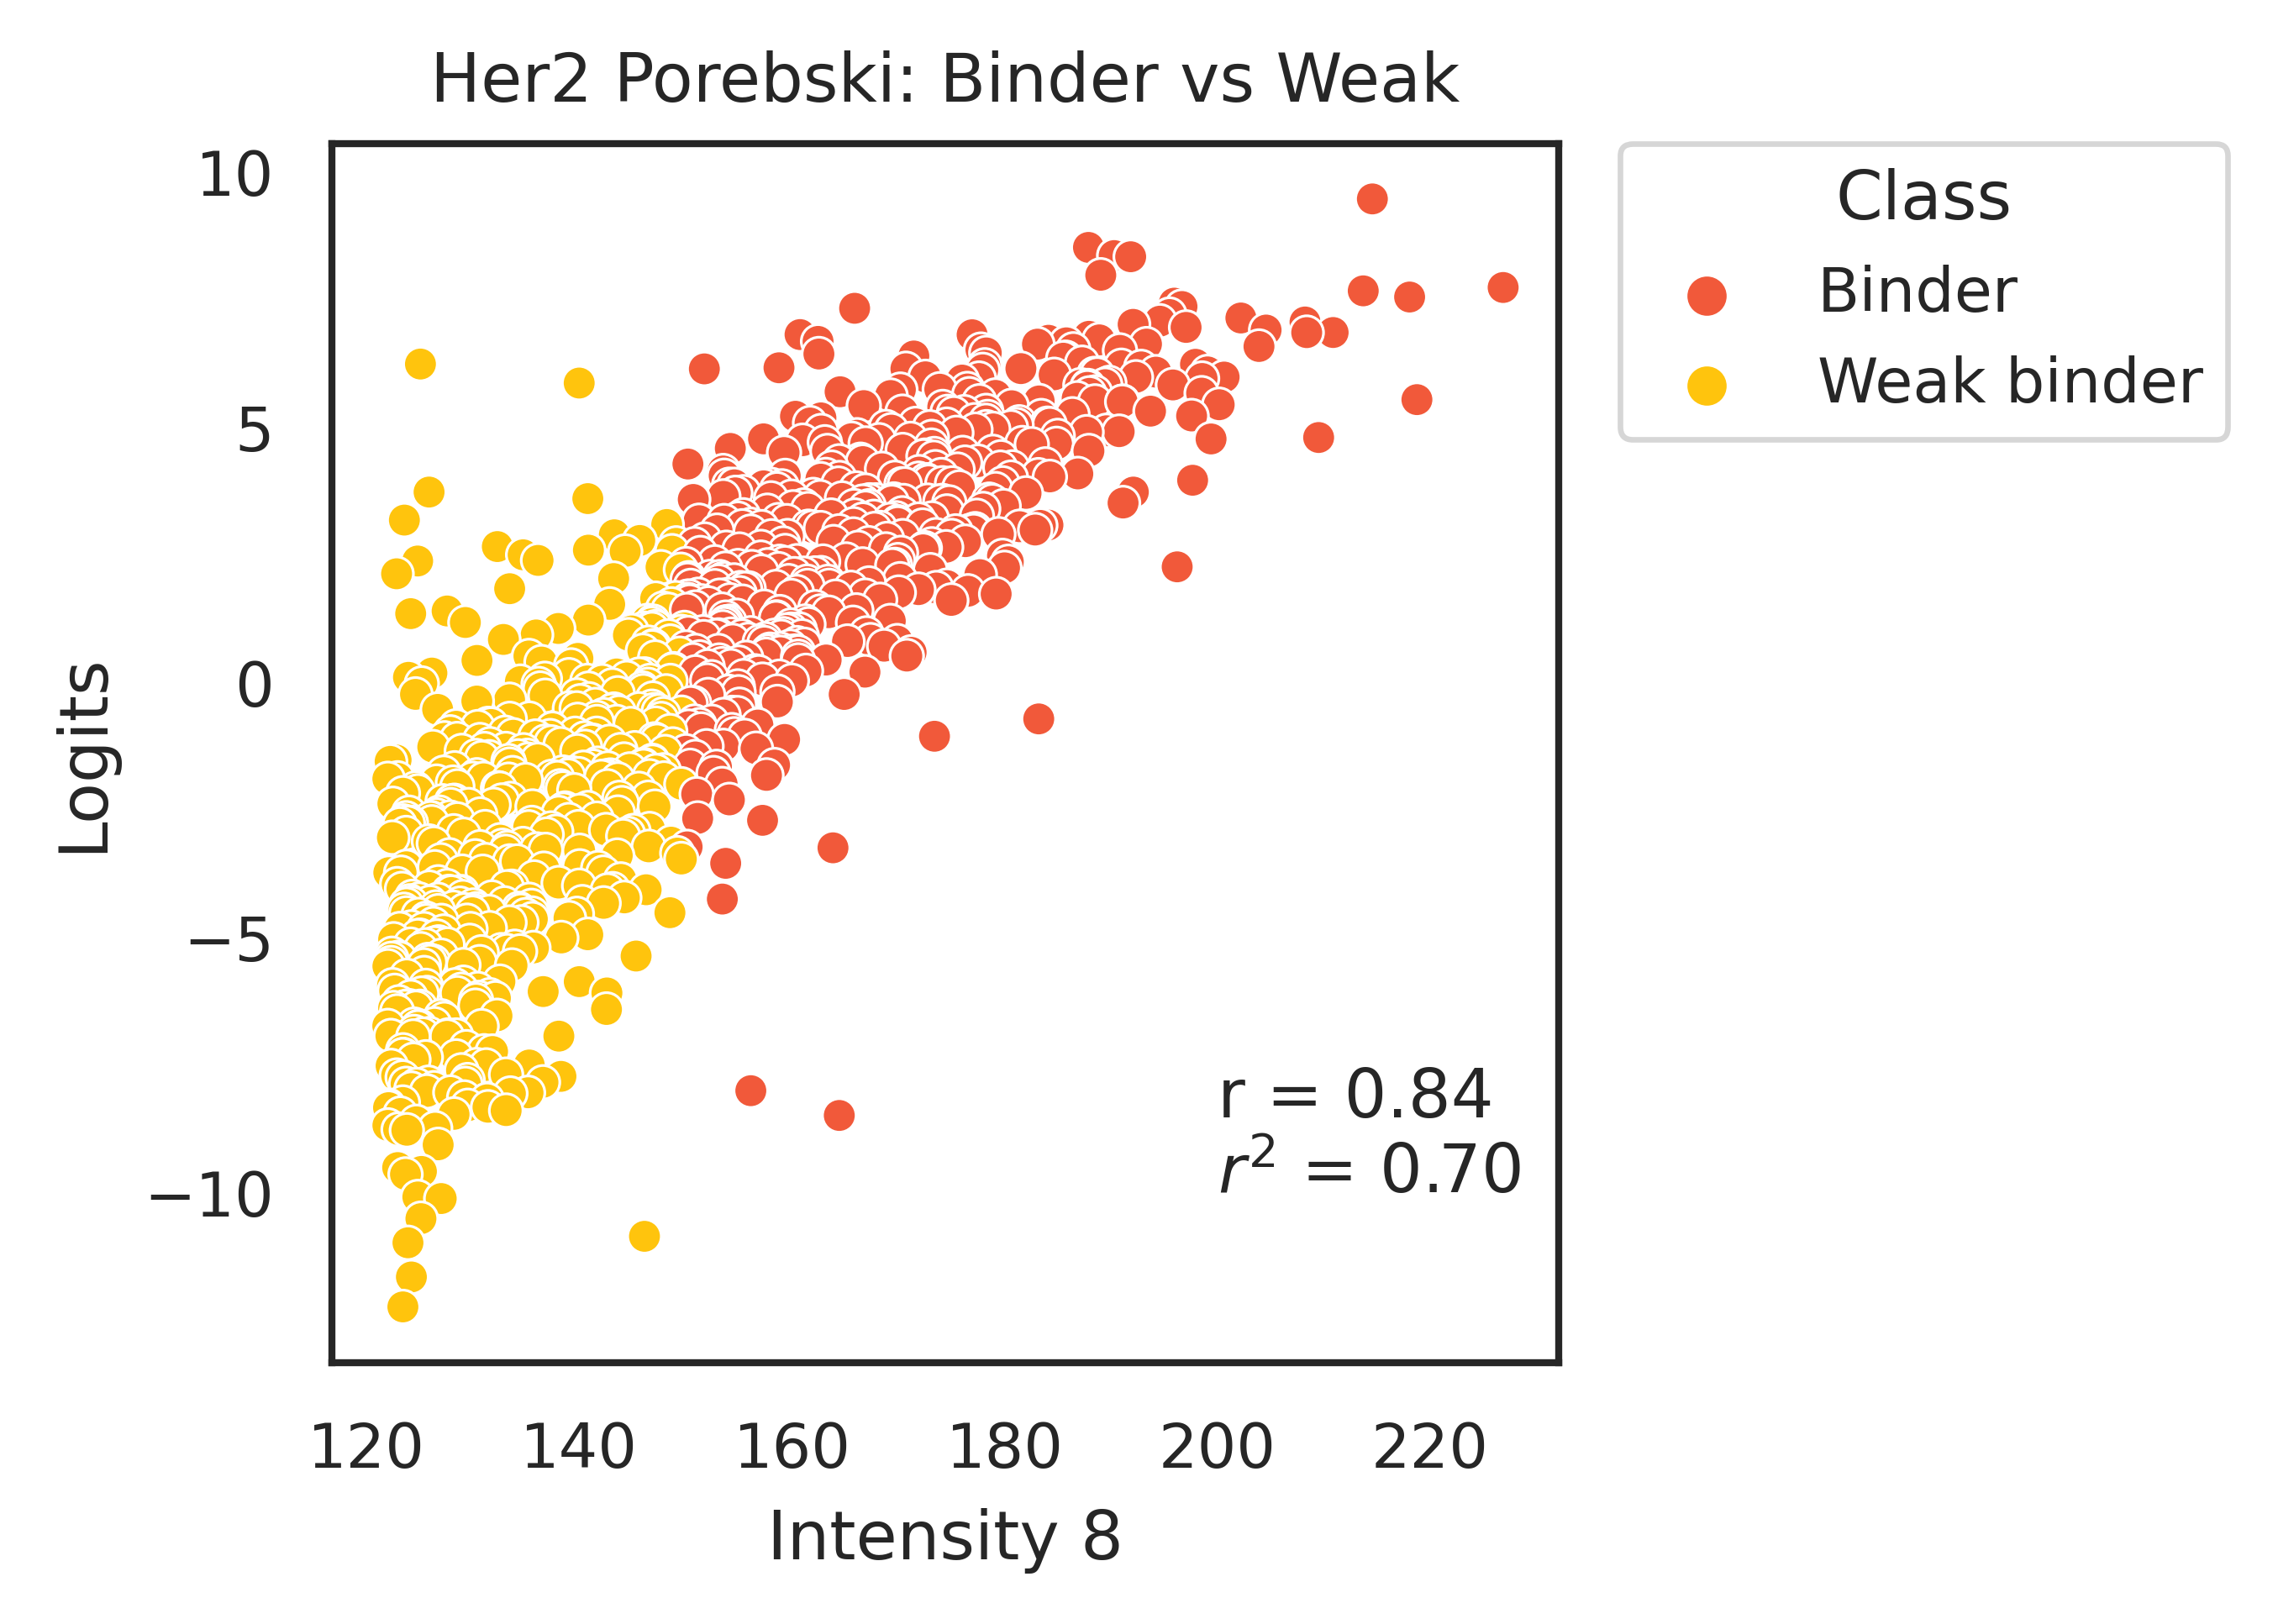

In [19]:
fig, ax = plt.subplots(figsize=(3.14, 3.14), dpi=600)
sns.set_theme(context="paper")
sns.set_style("white")

col_to_corr = "intensity 8"

cmap = [
    "#f1593a", # red
    "#ffc40d", # yellow
    "#28a3dc", # blue
]

sns.scatterplot(
    data=df,
    x=col_to_corr,
    y="logits",
    hue="class",
    ax=ax,
    palette=cmap,
)

# Add legend with legend title
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles,
    labels=["Binder", "Weak binder"],
    title="Class",
    loc="upper left",
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0,
)

ax.set_xlabel("Intensity 8")
ax.set_ylabel("Logits")
ax.set_title("Her2 Porebski: Binder vs Weak")
# ax.set_xticks(np.arange(-110, -89, 5))

# Add a coefficient of correlation and coeficient of determination
r, p = pearsonr(df[col_to_corr], df["logits"])
r2 = r ** 2
ax.text(
    200,
    -10,
    f"r = {r:.2f}\n$r^2$ = {r2:.2f}",
    bbox=dict(facecolor="white", alpha=0.5),
)

Logits ~ Energy

In [6]:
## Functions moved to utils_07. Can be refactored.

from itertools import permutations


task_types = (
    datasets.ClassificationTaskType.ONE_VS_ONE,
    datasets.ClassificationTaskType.ONE_VS_NINE,
    datasets.ClassificationTaskType.HIGH_VS_95LOW,
    datasets.ClassificationTaskType.HIGH_VS_LOOSER,
)

loader = datasets.FrozenMiniAbsolutMLLoader(
    data_dir=Path("../data/Frozen_MiniAbsolut_ML/")
)

def task_generator(task_types=task_types, loader=loader):
    """
    Generate tasks for which to compute attributions.
    """
    # Generate 1v1
    seed_split_ids = datasets.FrozenMiniAbsolutMLLoader.generate_seed_split_ids()
    for ag_1, ag_2 in permutations(config.ANTIGENS, r=2):
        for seed_id, split_id in seed_split_ids:            
            task = datasets.ClassificationTask(
                task_type=datasets.ClassificationTaskType.ONE_VS_ONE,
                ag_pos=ag_1,
                ag_neg=ag_2,
                seed_id=seed_id,
                split_id=split_id,
            )
            yield task
    
    # Generate the rest: 1v9, high vs 95low, high vs looser
    seed_split_ids = datasets.FrozenMiniAbsolutMLLoader.generate_seed_split_ids()
    for ag_1 in config.ANTIGENS:
        for seed_id, split_id in seed_split_ids:
            for task_type in task_types:
                
                if task_type == datasets.ClassificationTaskType.ONE_VS_ONE:
                    continue
                
                task = datasets.ClassificationTask(
                    task_type=task_type,
                    ag_pos=ag_1,
                    ag_neg="auto",
                    seed_id=seed_id,
                    split_id=split_id,
                )
                yield task


def get_miniabsolut_dataframes(task, load_energy_contributions=False):
    """Load the dataframes based on MiniAbsolut, from task
    These dataframes contain extra info, such as binding energies.
    """
    if task.split_id == 42:
        miniabsolut_path = Path("../data/MiniAbsolut")
    elif task.split_id in [0, 1, 2, 3, 4]:
        miniabsolut_path = Path(f"../data/MiniAbsolut_Splits/MiniAbsolut_Seed{task.split_id}")
    
    ag_pos_dir = miniabsolut_path / task.ag_pos
    if load_energy_contributions:
        ag_pos_dir = ag_pos_dir / "energy_contributions"
        suffix = "_absolut_energy_contributions"
        header = 1
    else:
        suffix = ""
        header = 0
    
    df_pos = pd.read_csv(ag_pos_dir / f"high_test_5000{suffix}.tsv", sep="\t", header=header)
    df_pos["class"] = "positive"

    if task.task_type == datasets.ClassificationTaskType.HIGH_VS_95LOW:
        df_neg = pd.read_csv(ag_pos_dir / f"95low_test_5000{suffix}.tsv", sep='\t', header=header)
        df_neg["class"] = "negative"
    elif task.task_type == datasets.ClassificationTaskType.HIGH_VS_LOOSER:
        df_neg = pd.read_csv(ag_pos_dir / f"looserX_test_5000{suffix}.tsv", sep='\t', header=header)
        df_neg["class"] = "negative"
    elif task.task_type in (datasets.ClassificationTaskType.ONE_VS_ONE, datasets.ClassificationTaskType.ONE_VS_NINE):
        # raise ValueError("Not implemented.")
        df_neg = pd.DataFrame()
    
    df = pd.concat([df_pos, df_neg], axis=0)
    
    return df

In [7]:
logit_energy_corr_path = "../data/Frozen_MiniAbsolut_ML/07e_LogitEnergyCorrelations.tsv"
force_run = False
skip_errors_logits = True

if Path(logit_energy_corr_path).exists() and not force_run:
    df_logits = pd.read_csv(logit_energy_corr_path, sep="\t")
else:

    records = []
    for task in task_generator():
        
        if skip_errors_logits:
            try:
                task = loader.load(task, attributions_toload="v2.0-2")
            except:
                continue
        else:
            task = loader.load(task, attributions_toload="v2.0-2")

        # Get energies
        df = get_miniabsolut_dataframes(task)

        # Add logits to df
        df_attr = pd.DataFrame.from_records(task.attributions)
        df = pd.merge(df, df_attr[["slide", "logits"]], left_on="Slide", right_on="slide", how='left')

        # Compute correlation and p-val with scipy for all and positive class
        r, p = pearsonr(df["logits"], df["Energy"])
        r_pos, p_pos = pearsonr(df[df["class"] == "positive"]["logits"], df[df["class"] == "positive"]["Energy"])

        # Compute slope for all and positive class
        slope, intercept = np.polyfit(df["logits"], df["Energy"], 1)
        slope_pos, intercept_pos = np.polyfit(df[df["class"] == "positive"]["logits"], df[df["class"] == "positive"]["Energy"], 1)
        
        records.append({
            "task_type": task.task_type.to_str(),
            "ag_pos": task.ag_pos,
            "ag_neg": task.ag_neg,
            "seed_id": task.seed_id,
            "split_id": task.split_id,
            "r": r,
            "p": p,
            "r2": r**2,
            "r_pos": r_pos,
            "r_pos2": r_pos**2,
            "p_pos": p_pos,
            "slope": slope,
            "intercept": intercept,
            "slope_pos": slope_pos,
            "intercept_pos": intercept_pos,
            "logits_mean": df["logits"].mean(),
            "logits_std": df["logits"].std(),
            "Energy_mean": df["Energy"].mean(),
            "Energy_std": df["Energy"].std(),
            "logits_pos_mean": df[df["class"] == "positive"]["logits"].mean(),
            "logits_pos_std": df[df["class"] == "positive"]["logits"].std(),
            "Energy_pos_mean": df[df["class"] == "positive"]["Energy"].mean(),
            "Energy_pos_std": df[df["class"] == "positive"]["Energy"].std(),
            "logits_neg_mean": df[df["class"] == "negative"]["logits"].mean(),
            "logits_neg_std": df[df["class"] == "negative"]["logits"].std(),
            "Energy_neg_mean": df[df["class"] == "negative"]["Energy"].mean(),
            "Energy_neg_std": df[df["class"] == "negative"]["Energy"].std(),
        })

    df_logits = pd.DataFrame.from_records(records)
    df_logits.to_csv(logit_energy_corr_path, index=False, sep='\t')

In [8]:
# Correcting an error in the collection of the results by merging new and old LogitEnergyCorrelations.
df_logits_old = pd.read_csv("../data/Frozen_MiniAbsolut_ML/07e_LogitEnergyCorrelations_old.tsv", sep="\t")
df_logits_new = pd.concat(
    [
        df_logits.query("task_type == '1v1'").copy(),
        df_logits_old.query("task_type != '1v1'").copy(),
    ],
    axis=0
)
df_logits_new.task_type.value_counts()
df_logits = df_logits_new.copy()

In [11]:
### No need to do the correction from below, we already computed for both ways!
### Double check: df_logits.query("task_type == '1v1'").query("ag_pos in ['3VRL', '1NSN'] and ag_neg in ['3VRL', '1NSN']")

## Correct for double antigen contribution from 1v1 (to pos and negative, symmetric)
# df_logits_1v1 = df_logits.loc[df_logits["task_type"] == "1v1"].copy()
# ag_pos_series = df_logits_1v1["ag_pos"]
# df_logits_1v1["ag_pos"] = df_logits_1v1["ag_neg"]
# df_logits_1v1["ag_neg"] = ag_pos_series
# del ag_pos_series
# df_logits = pd.concat([df_logits, df_logits_1v1], axis=0)

In [12]:
# fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)
# sns.set_theme(context="paper")
# sns.set_style("white")

# sns.stripplot(data=df_logits, x="task_type", y="logits_pos_mean", hue="ag_pos", ax=ax)

# # Disable legend
# ax.legend_.remove()

# # ax.set_title("Logits mean for positive class")
# ax.set_ylabel("Mean(Logit) for the positive class")
# ax.set_xlabel("Task type")

In [13]:
# sns.stripplot(data=df_logits, x="task_type", y="Energy_pos_mean", hue="ag_pos")

In [14]:
df_logits.groupby(["task_type"]).agg({"r_pos": ["min", "median", "max"]})

r_pos                    
                     min    median       max
task_type                                   
1v1            -0.613358 -0.047297  0.319436
1v9            -0.771730 -0.192282  0.204192
high_vs_95low  -0.846448 -0.506698 -0.286192
high_vs_looser -0.897692 -0.615479 -0.326624

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/seaborn/categorical.py:299: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(sub_data["x"], sub_data["y"], color=color, **plot_kws)
/tmp/ipykernel_3252277/2258301069.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))


Text(0.5, 0, 'Task')

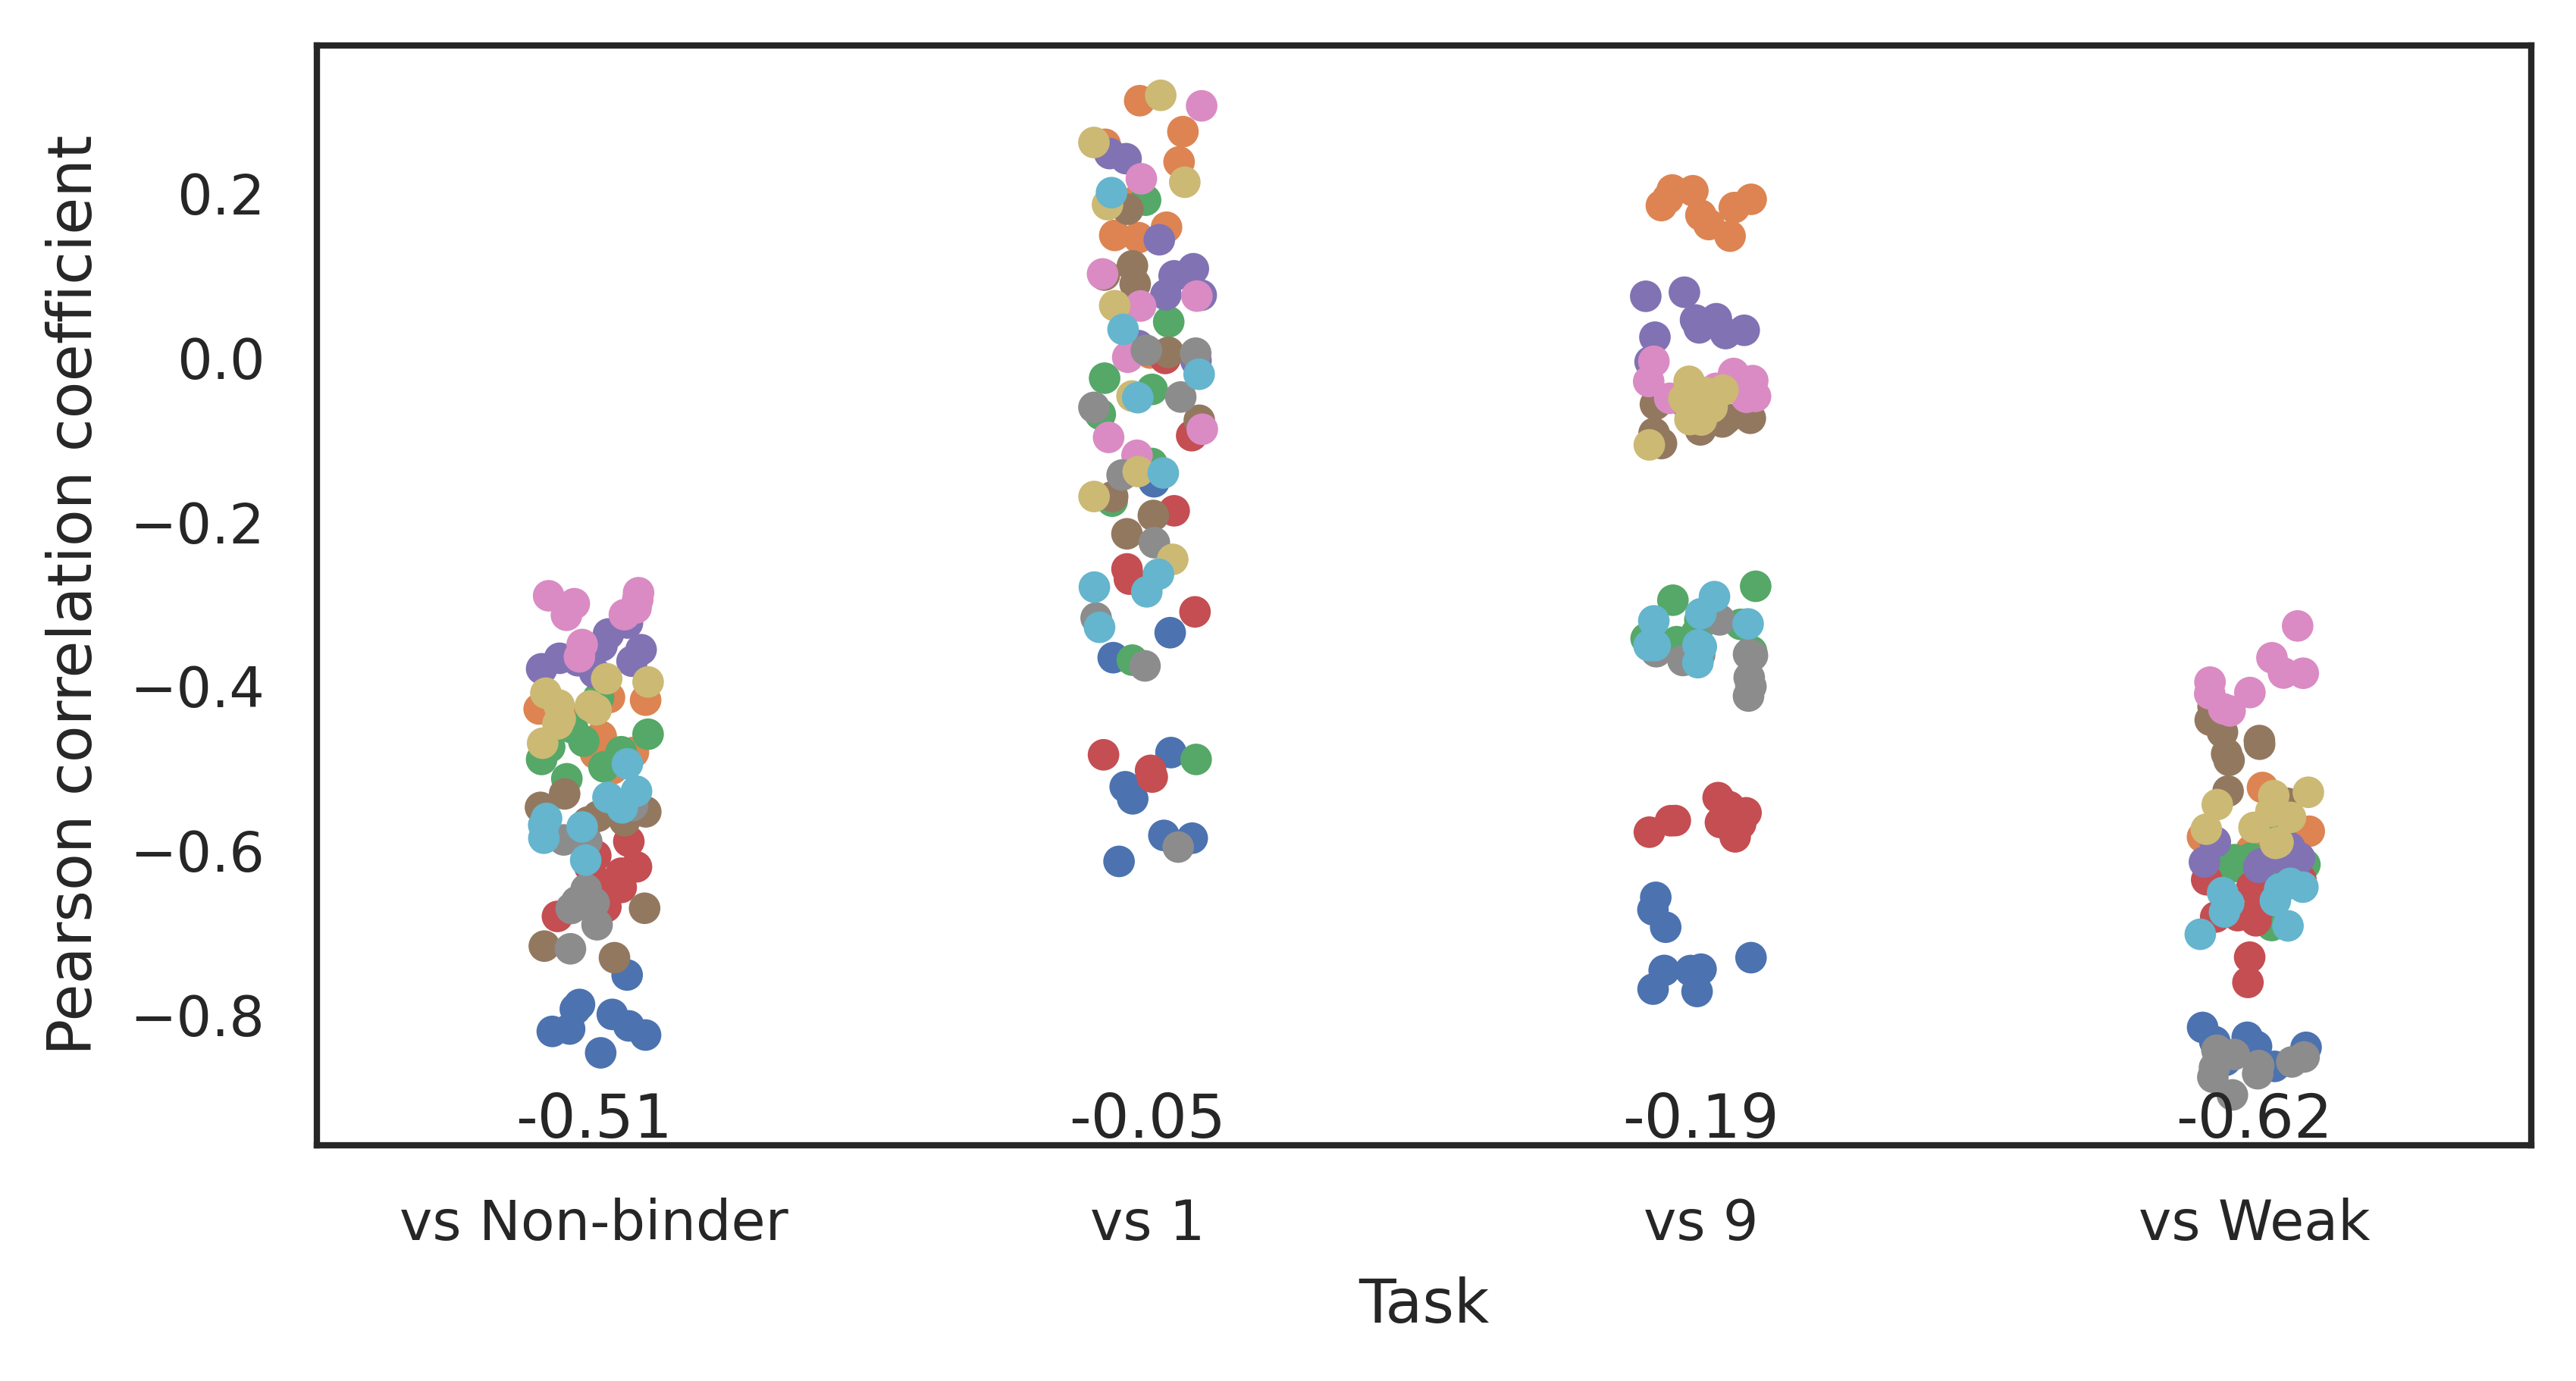

In [15]:
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)
# sns.set_theme(context="paper")
# sns.set_style("white")

task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
sns.stripplot(
    data=df_logits, 
    x="task_type", 
    y="r_pos", 
    hue="ag_pos", 
    ax=ax, 
    cmap=visualisations.PlotParams.cmap_antigens,
    order=task_order,
)

# Display no legend
ax.legend_.remove()

# Relabel xticks
ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))

# Add median r_pos per task
r_median_df = df_logits.groupby(["task_type"]).agg({"r_pos": "median"})
for i, row in r_median_df.iterrows():
    ax.text(
        i,
        -0.95,
        f"{row['r_pos']:.2f}",
        # Center center
        horizontalalignment='center',
    )


ax.set_ylabel("Pearson correlation coefficient")
ax.set_xlabel("Task")

In [16]:
# Anova test that all are different
from scipy.stats import f_oneway
f_oneway(
    df_logits.query("task_type == 'high_vs_95low'")["r_pos"],
    df_logits.query("task_type == '1v1'")["r_pos"],
    df_logits.query("task_type == '1v9'")["r_pos"],
    df_logits.query("task_type == 'high_vs_looser'")["r_pos"],
)

F_onewayResult(statistic=132.9461919297828, pvalue=8.73375238666368e-58)

In [17]:
# Associations with linear performance
df_acc = pd.read_csv("../data/Frozen_MiniAbsolut_ML/df_task_data_processed.tsv", sep='\t')
df_acc.head()

seed_id  split_id task_type ag_pos ag_neg  acc_closed model_type
0        0         0       1v1   1ADQ   1FBI    0.977471       SN10
1        0         0       1v1   1ADQ   1H0D    0.974257       SN10
2        0         0       1v1   1ADQ   1NSN    0.973757       SN10
3        0         0       1v1   1ADQ   1OB1    0.976157       SN10
4        0         0       1v1   1ADQ   1WEJ    0.967686       SN10

In [18]:
# Define a task column. If task_type 1v1, then ag_pos, ag_neg follow alphanumeric sorting.
def define_task_col(df):
    tasks = []
    for i, row in df.iterrows():
        if row["task_type"] == "1v1":
            ag_1, ag_2 = tuple(sorted([row["ag_pos"], row["ag_neg"]]))
        else:
            ag_1 = row["ag_pos"]
            ag_2 = row["ag_neg"]
        
        if "_" in ag_1:
            ag_1 = ag_1.split("_")[0]

        if "_" in ag_2:
            ag_2 = ag_2.split("_")[0]
        
        if row["task_type"] == "1v9":
            ag_2 = "v9"
        elif ag_2 == "auto" and row["task_type"] != "1v9":
            ag_2 = ag_1

        task = f"{row['task_type']}_{ag_1}_{ag_2}"
        tasks.append(task)

    df["task"] = tasks


define_task_col(df_logits)
define_task_col(df_acc)

In [19]:
# Aggregate acc based on task
df_acc_agg = df_acc.groupby(["task", "task_type"]).agg({"acc_closed": "mean"}).reset_index()

# Aggregate logits correlation based on task
df_logits_agg = df_logits.groupby(["task", "task_type"]).agg({"r_pos": "mean"}).reset_index()

# Merge
df_merged = pd.merge(df_acc_agg, df_logits_agg, on=["task", "task_type"], how='inner')

<AxesSubplot: xlabel='acc_closed', ylabel='r_pos'>

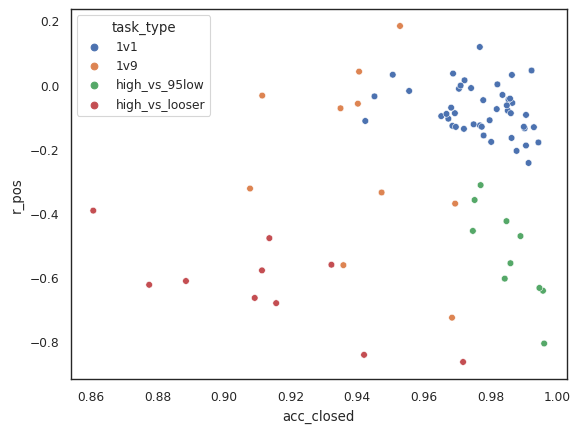

In [20]:
sns.scatterplot(
    data=df_merged,
    x="acc_closed",
    y="r_pos",
    hue="task_type",
)

In [21]:
df_merged

task       task_type  acc_closed     r_pos
0              1v1_1ADQ_1FBI             1v1    0.977923 -0.158201
1              1v1_1ADQ_1H0D             1v1    0.974163 -0.010504
2              1v1_1ADQ_1NSN             1v1    0.972200  0.013661
3              1v1_1ADQ_1OB1             1v1    0.976816 -0.126659
4              1v1_1ADQ_1WEJ             1v1    0.968755  0.034684
..                       ...             ...         ...       ...
70  high_vs_looser_1WEJ_1WEJ  high_vs_looser    0.913621 -0.477966
71  high_vs_looser_2YPV_2YPV  high_vs_looser    0.932250 -0.560745
72  high_vs_looser_3RAJ_3RAJ  high_vs_looser    0.877557 -0.623275
73  high_vs_looser_3VRL_3VRL  high_vs_looser    0.942043 -0.841433
74  high_vs_looser_5E94_5E94  high_vs_looser    0.915668 -0.680337

[75 rows x 4 columns]

vs 1
vs 9
vs Non-binder
vs Weak


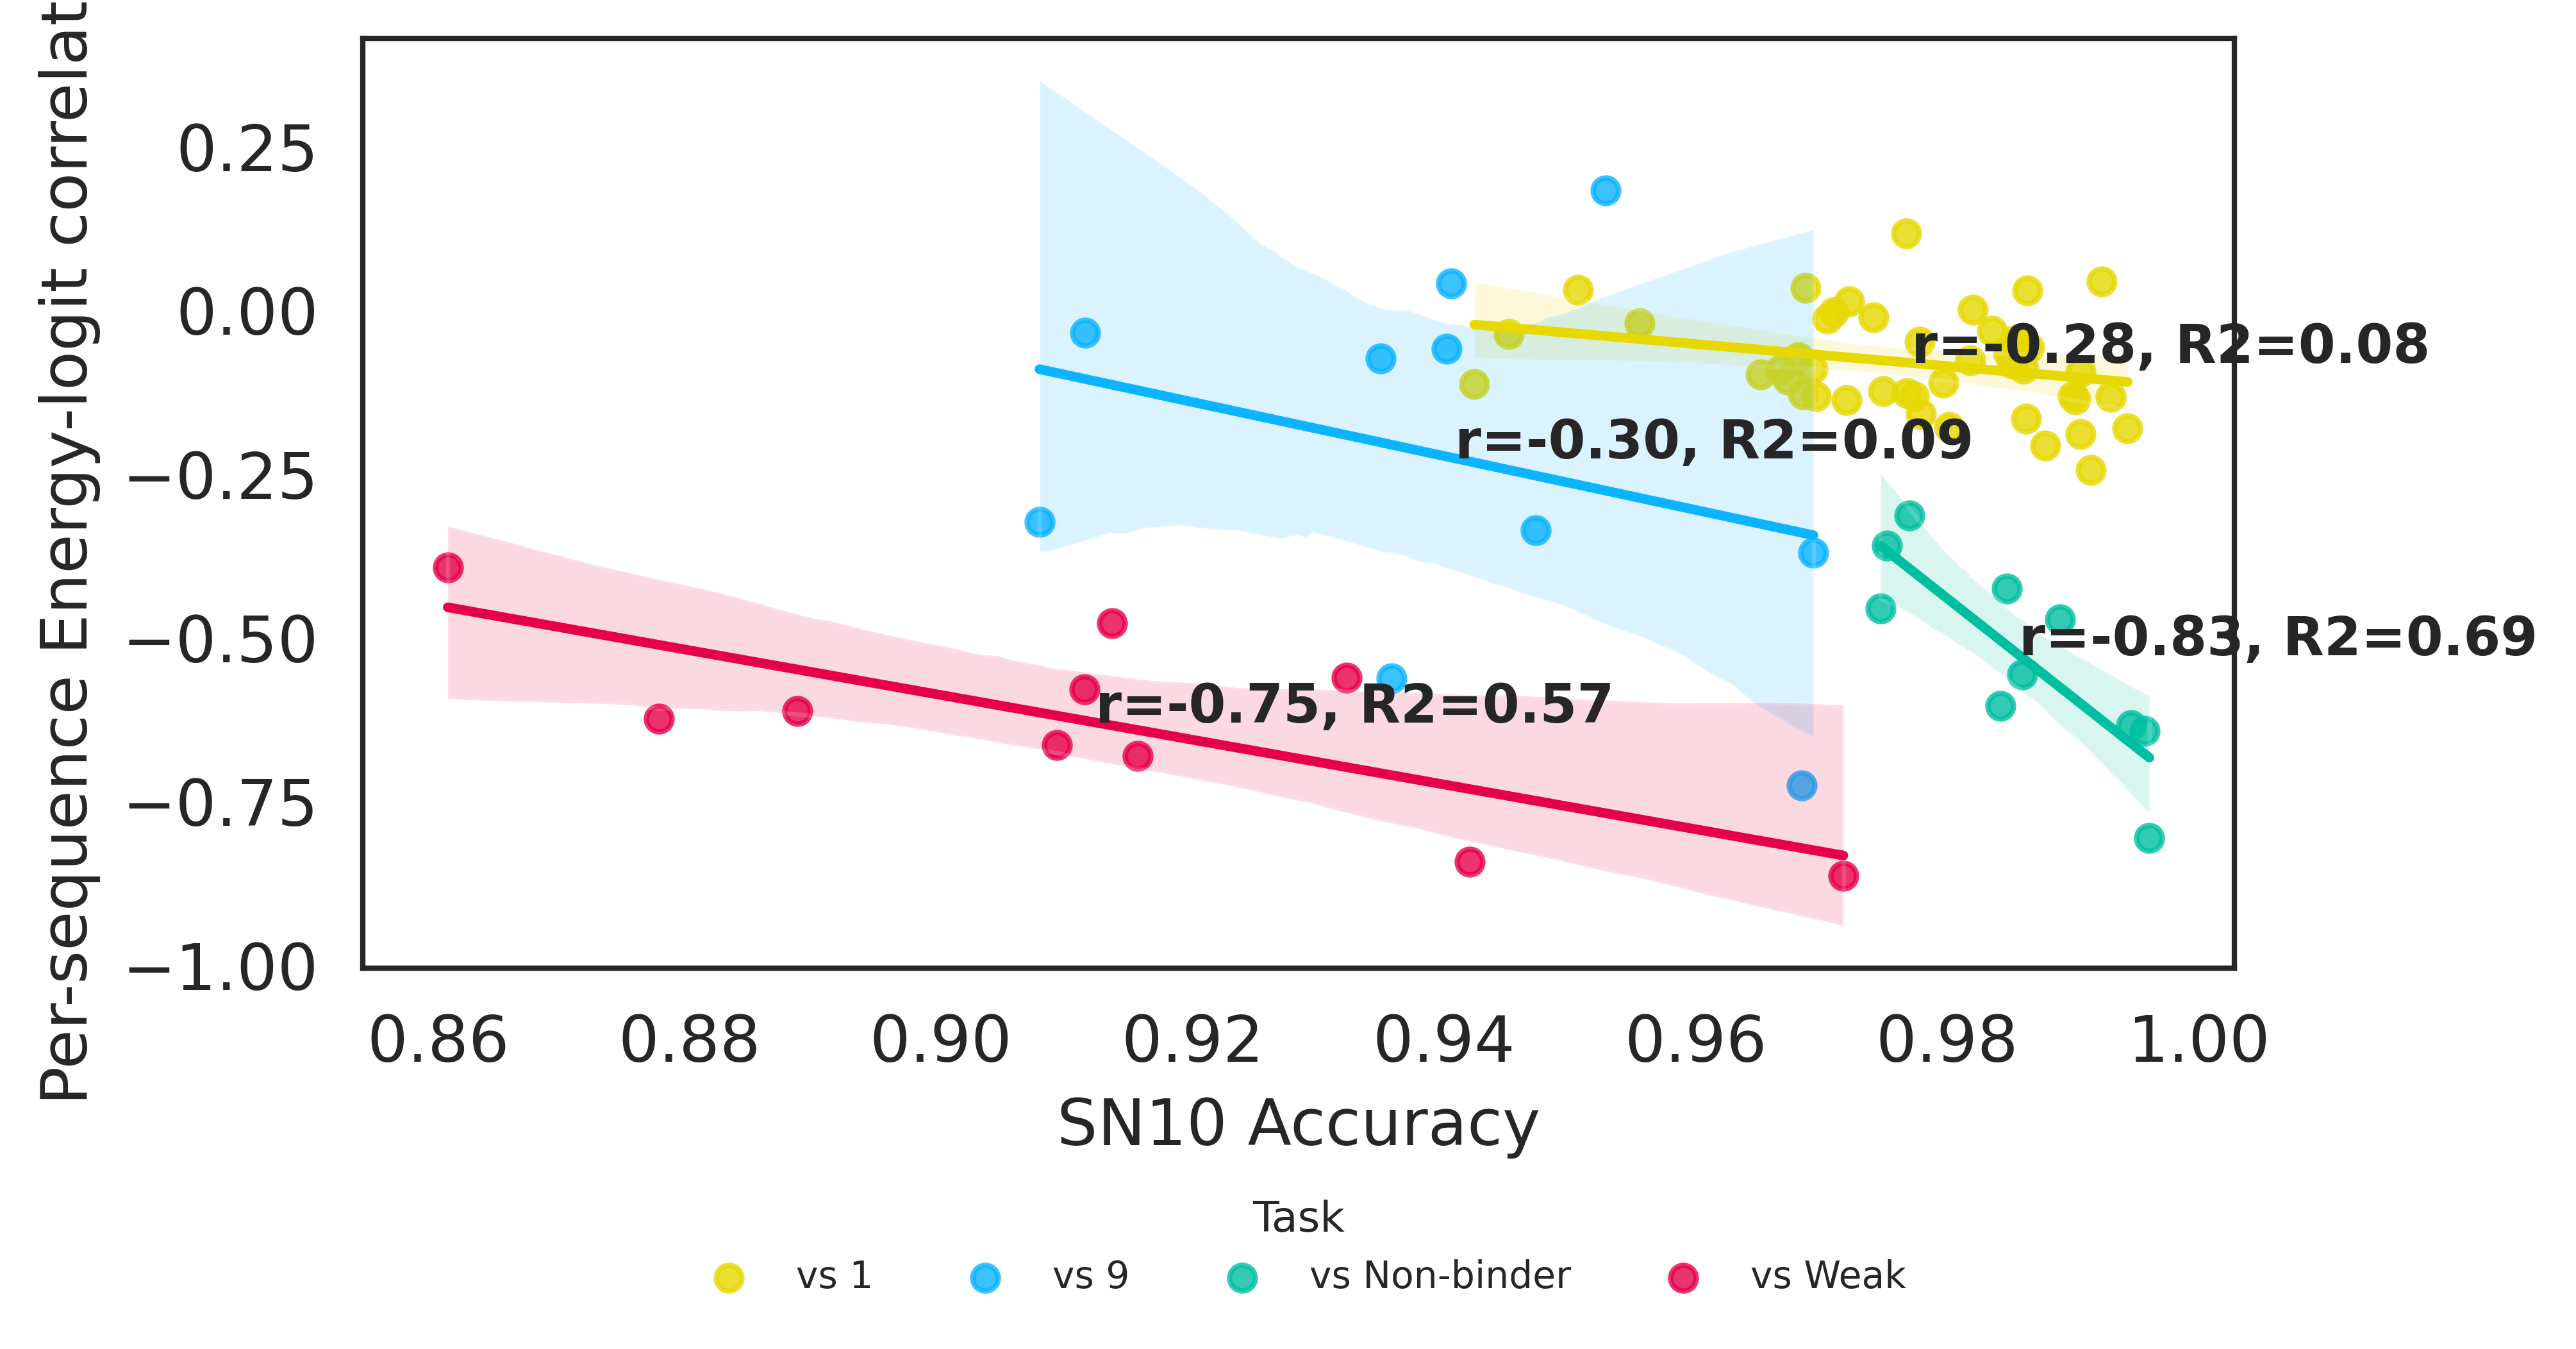

In [22]:
from scipy.stats import pearsonr

cmap = visualisations.PlotParams.cmap_tasks

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)

# Map to tasks clean
df_merged["task_type_clean"] = df_merged["task_type"].map(visualisations.PlotParams.map_task_type_to_clean)

# Line plot in seaborn with R2 regression
for i, df_g in df_merged.groupby("task_type_clean"):
    print(i)
    color = cmap[visualisations.PlotParams.order_tasks_clean.index(i)] # type: ignore
    sns.regplot(
        x="acc_closed",
        y="r_pos",
        data=df_g,
        scatter=True,
        color=color,
        ax=ax,
        label=i,
    )

    # Compute Pearson correlation
    r, pval = pearsonr(df_g["r_pos"], df_g["acc_closed"])
    # Add text with r and R2 at centroid
    y = df_g["r_pos"].mean()
    x = df_g["acc_closed"].mean()
    ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f}", fontsize=10, fontweight="bold")

FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_ylabel("Per-sequence Energy-logit correlation", fontsize=FONT_SIZE)
ax.set_xlabel("SN10 Accuracy", fontsize=FONT_SIZE)

# ax.set_yticks(yticks)

# Title
# ax.set_title("Relationship beteen SN10 accuracy and Jensen-Shannon Divergence (JSD)", fontsize=FONT_SIZE)

# fig.savefig("figures/1B.svg")
fig.show()

In [23]:
# fig, ax = plt.subplots(figsize=(10, 10))
# sns.boxplot(data=df_logits, x="task_type", y="r_pos", hue="ag_pos", ax=ax)
# ax.set_title("Correlation between logits and binding energy for MiniAbsolut tasks")

In [24]:
# Logits pos mean and logits ~ energy correlation rank relation
# Low
df_logits.groupby(["task_type", "ag_pos"])[["logits_pos_mean", "r_pos"]].mean().corr()

logits_pos_mean     r_pos
logits_pos_mean         1.000000  0.310216
r_pos                   0.310216  1.000000

Energy contributions ~ Attributions correlations

In [25]:
from utils_07 import get_attr_from_records, get_onehotstack_from_records
# ### COPIED FROM 25b (REFACTOR LATER)
# def get_attr_from_records(records, attributor_name, y_true):
#     """Get the attributions for a given attributor and y_true."""
#     attr = np.stack(
#         list(map(
#             lambda x: np.array(x[attributor_name]).reshape((11, 20)),
#             filter(lambda x: x["y_true"] in y_true, records)
#         )))
        
#     return attr

# def get_onehotstack_from_records(records, y_true = (0, 1)):
#     """Get the onehot stack from the records."""
#     slides = [record["slide"] for record in records if record["y_true"] in y_true]
#     onehots = [preprocessing.onehot_encode(slide) for slide in slides]
#     onehot_stack = np.stack(onehots)
#     return onehot_stack


In [26]:
from utils_07 import load_energy_contributions_from_task_nonlinear_version
# def load_energy_contributions_from_task_nonlinear_version(task, load_slide_df = False):

#     # Get energy contributions and attributions
#     df = get_miniabsolut_dataframes(task, load_energy_contributions=True)
#     energy_dict = df.set_index("Slide").to_dict(orient="index")
#     for slide in energy_dict.keys():
#         energy_dict[slide]["energies"] = utils.extract_contributions_from_string(energy_dict[slide]["contribPerAAparaBind"])[1]
#         energy_dict[slide]["energies_fold"] = utils.extract_contributions_from_string(energy_dict[slide]["contribPerAAparaFold"])[1]
#         energy_dict[slide]["energies_total"] = (np.array(energy_dict[slide]["energies"]) + np.array(energy_dict[slide]["energies_fold"])).tolist()

#     # Get attributions per amino acid
#     task = loader.load(task, attributions_toload="v2.0-2")
#     attributor_name = "DeepLIFT_LOCAL_v2.0-2"
#     attr_stack = get_attr_from_records(task.attributions, attributor_name, (0, 1))  # Nx11x20
#     onehot_stack = get_onehotstack_from_records(task.attributions, (0, 1))  # Nx220
#     attr_aa = attr_stack[onehot_stack.reshape((-1, 11, 20)) == 1].reshape(-1, 11)  # Nx11
#     attr_dict = {record["slide"]: {**record, **{"attribution_existingaa": attr_aa[i, :]}}
#                 for i, record in enumerate(task.attributions)}

#     # Combine dictionaries
#     slide_records = []
#     for slide in energy_dict.keys():
#         dataset_class = energy_dict[slide]["class"]
#         energies = energy_dict[slide]["energies"]
#         energies_fold = energy_dict[slide]["energies_fold"]
#         energies_total = energy_dict[slide]["energies_total"]
#         attrs = attr_dict[slide]["attribution_existingaa"]
        
#         # Correlation between energy and attribution with scipy
#         r, p = pearsonr(energies, attrs)
#         r_fold, p_fold = pearsonr(energies_fold, attrs)
#         r_total, p_total = pearsonr(energies_total, attrs)
#         slide_records.append({
#             "slide": slide,
#             "class": dataset_class,
#             "energies": energies,
#             "attributions": attrs,
#             "r": r,
#             "p": p,
#             "r_fold": r_fold,
#             "p_fold": p_fold,
#             "r_total": r_total,
#             "p_total": p_total,
#         })
#     slide_df = pd.DataFrame.from_records(slide_records)
    
#     mean = slide_df["r"].mean()
#     std = slide_df["r"].std()
#     mean_pos = slide_df[slide_df["class"] == "positive"]["r"].mean()
#     std_pos = slide_df[slide_df["class"] == "positive"]["r"].std()
#     mean_neg = slide_df[slide_df["class"] == "negative"]["r"].mean()
#     std_neg = slide_df[slide_df["class"] == "negative"]["r"].std()

#     mean_fold = slide_df["r_fold"].mean()
#     std_fold = slide_df["r_fold"].std()
#     mean_pos_fold = slide_df[slide_df["class"] == "positive"]["r_fold"].mean()
#     std_pos_fold = slide_df[slide_df["class"] == "positive"]["r_fold"].std()
#     mean_neg_fold = slide_df[slide_df["class"] == "negative"]["r_fold"].mean()
#     std_neg_fold = slide_df[slide_df["class"] == "negative"]["r_fold"].std()

#     mean_total = slide_df["r_total"].mean()
#     std_total = slide_df["r_total"].std()
#     mean_pos_total = slide_df[slide_df["class"] == "positive"]["r_total"].mean()
#     std_pos_total = slide_df[slide_df["class"] == "positive"]["r_total"].std()
#     mean_neg_total = slide_df[slide_df["class"] == "negative"]["r_total"].mean()
#     std_neg_total = slide_df[slide_df["class"] == "negative"]["r_total"].std()
    
#     stats = {
#         "task_type": task.task_type.to_str(),
#         "ag_pos": task.ag_pos,
#         "ag_neg": task.ag_neg,
#         "seed_id": task.seed_id,
#         "split_id": task.split_id,
#         "mean": mean,
#         "std": std,
#         "mean_pos": mean_pos,
#         "std_pos": std_pos,
#         "mean_neg": mean_neg,
#         "std_neg": std_neg,
#         "mean_fold": mean_fold,
#         "std_fold": std_fold,
#         "mean_pos_fold": mean_pos_fold,
#         "std_pos_fold": std_pos_fold,
#         "mean_neg_fold": mean_neg_fold,
#         "std_neg_fold": std_neg_fold,
#         "mean_total": mean_total,
#         "std_total": std_total,
#         "mean_pos_total": mean_pos_total,
#         "std_pos_total": std_pos_total,
#         "mean_neg_total": mean_neg_total,
#         "std_neg_total": std_neg_total,
#     }
#     if load_slide_df:
#         return stats, slide_df
#     else:
#         return stats


In [27]:
# df_attrib_cache = df_attrib.copy()

In [28]:
energy_contributions_path = "../data/Frozen_MiniAbsolut_ML/07e_EnergyContributions.tsv"
# energy_contributions_path = "../data/Frozen_MiniAbsolut_ML/07e_EnergyContributions_1v1.tsv"
force_run_contrib = False
skip_errors_contrib = True

if Path(energy_contributions_path).exists() and not force_run_contrib:
    df_attrib = pd.read_csv(energy_contributions_path, sep="\t")
else:

    records = []
    # for task in task_generator():
    for task in task_generator():
        
        if skip_errors_contrib:
            try:
                stats = load_energy_contributions_from_task_nonlinear_version(task)
            except:
                continue
        else:
            stats = load_energy_contributions_from_task_nonlinear_version(task)
        
        records.append(stats)

    df_attrib = pd.DataFrame.from_records(records)
    df_attrib.to_csv(energy_contributions_path, index=False, sep='\t')

In [ ]:
## As above for the logits case, no need to duplicate for 1v1, since
##  we already have computed the associations for both ways!
## Double check with:
# df_attrib.query("task_type == '1v1'").query("ag_pos in ['3VRL', '1NSN'] and ag_neg in ['3VRL', '1NSN']")


# # Duplicate 1v1 and reverse pos with negative to account for double contributions
# df_attrib_1v1 = df_attrib.loc[df_attrib["task_type"] == "ONE_VS_ONE"].copy()
# ag_pos_col = df_attrib_1v1["ag_pos"]
# df_attrib_1v1["ag_pos"] = df_attrib_1v1["ag_neg"]
# df_attrib_1v1["ag_neg"] = ag_pos_col
# del ag_pos_col

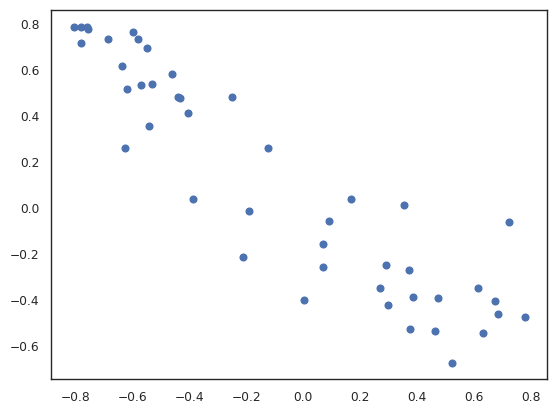

In [30]:
## There is a pattern for 1v1 when one looks at the correlation between forward and backwards, there is antisymmetry!

from itertools import combinations

df_attrib_1v1 = df_attrib.query("task_type == '1v1'").copy()
ags = df_attrib_1v1.ag_pos.unique().tolist()

res = []
for ag_1, ag_2 in combinations(ags, r=2):
    r_fwd = df_attrib_1v1.query("ag_pos == @ag_1 and ag_neg == @ag_2").mean_pos_total.median()
    r_bwd = df_attrib_1v1.query("ag_pos == @ag_2 and ag_neg == @ag_1").mean_pos_total.median()
    res.append({
        "ag_1": ag_1,
        "ag_2": ag_2,
        "r_fwd": r_fwd,
        "r_bwd": r_bwd,
    })

plt.plot([r["r_fwd"] for r in res], [r["r_bwd"] for r in res], 'o')

In [ ]:
# sns.catplot(
#     data=df_attrib, 
#     x="task_type", 
#     y="mean_pos", 
#     hue="ag_pos")

In [ ]:
# sns.catplot(
#     data=df_attrib, 
#     x="task_type", 
#     y="std", 
#     hue="ag_pos")

In [ ]:
# # Combined plots from logits and contributions
# df_logits["corr_type"] = "logits"

# df_attrib["corr_type"] = "attributions"
# df_attrib["r_pos"] = df_attrib["mean_pos"]

# df_combined = pd.concat([df_logits, df_attrib])

# fig, ax = plt.subplots(figsize=(10, 10))
# sns.boxplot(data=df_combined, x="task_type", y="r_pos", hue="corr_type", ax=ax)

In [ ]:
# df_combined["type"] = df_combined["task_type"] + "_" + df_combined["corr_type"]

# fig, ax = plt.subplots(figsize=(10, 10))
# sns.stripplot(
#     data=df_combined, 
#     x="type", 
#     y="r_pos", 
#     hue="ag_pos",
#     order= [
#         "1v1_logits", "1v1_attributions", "1v9_logits", "1v9_attributions",
#         "high_vs_95low_logits", "high_vs_95low_attributions", "high_vs_looser_logits", "high_vs_looser_attributions"
#     ],
#     jitter=0.2,
#     ax=ax,
# )
# # Rotate x-axis labels 90
# for item in ax.get_xticklabels():
#     item.set_rotation(90)

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/seaborn/categorical.py:299: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(sub_data["x"], sub_data["y"], color=color, **plot_kws)
/tmp/ipykernel_1363179/1171396604.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))


Text(0.5, 0, 'Task')

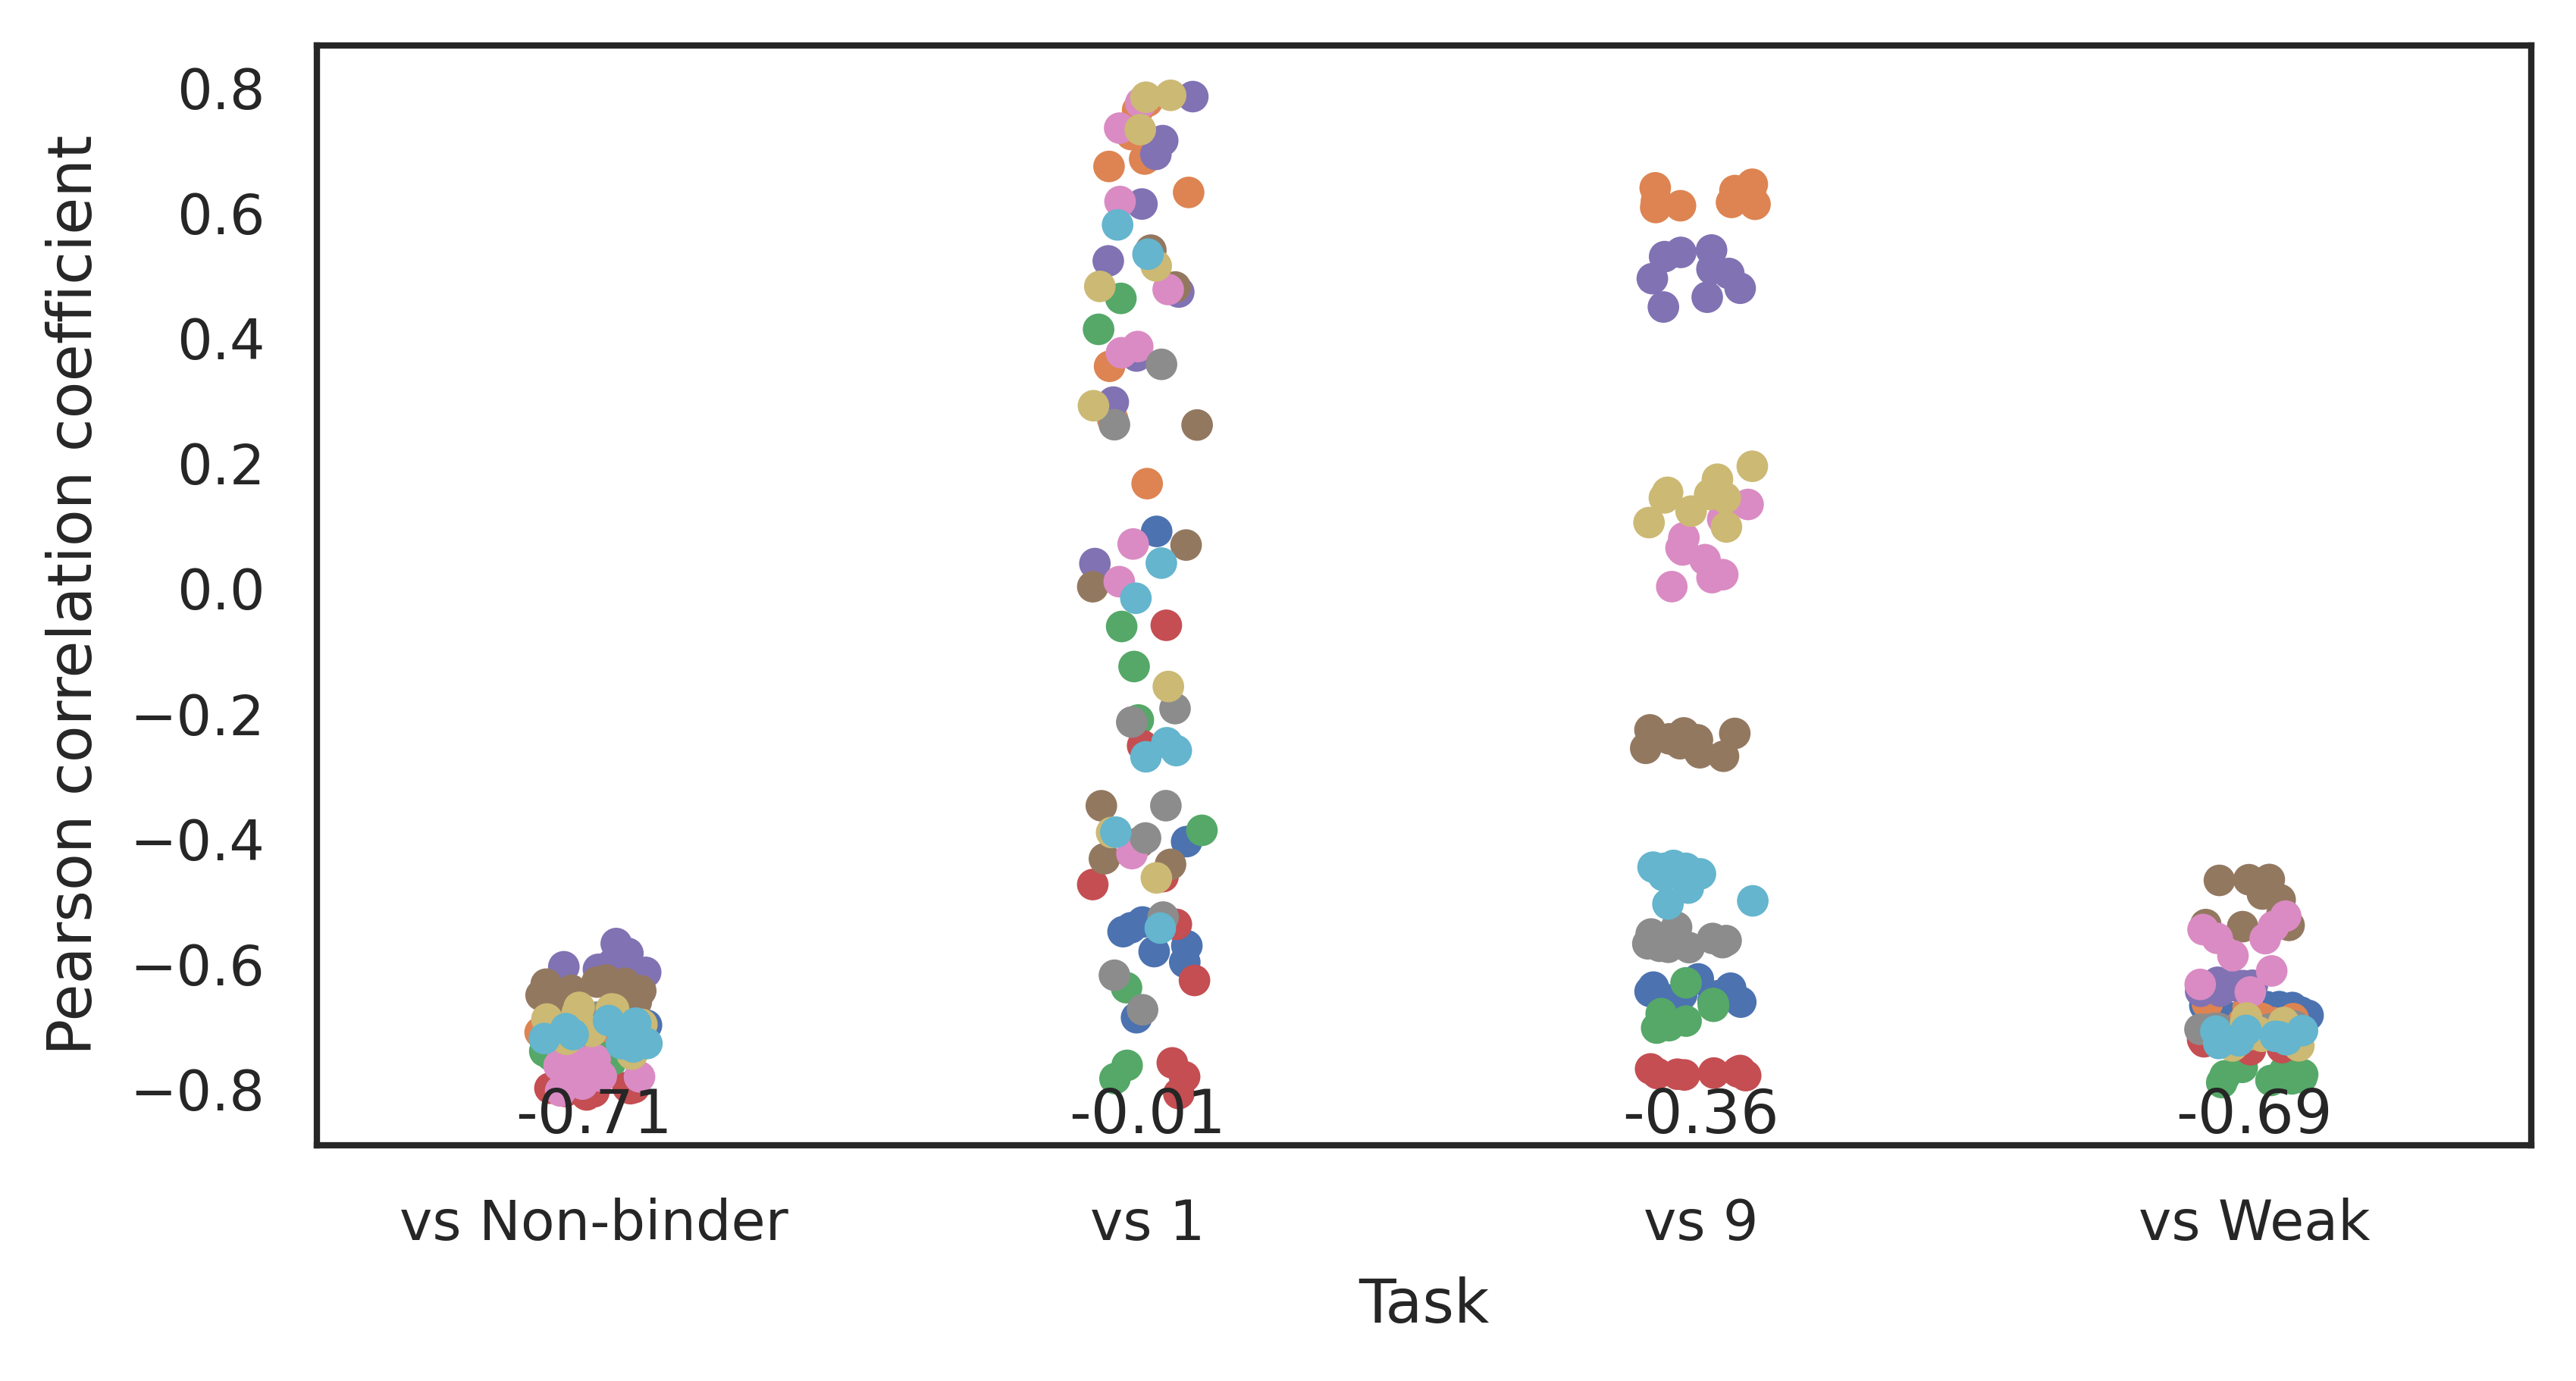

In [ ]:
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)
sns.set_theme(context="paper")
sns.set_style("white")

task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
sns.stripplot(
    data=df_attrib, 
    x="task_type", 
    y="mean_pos_total", 
    order=task_order,
    hue="ag_pos",
    ax=ax,
    cmap=visualisations.PlotParams.cmap_antigens,
)

ax.legend_.remove()

# Relabel xticks
ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))

# Add median r_pos per task
r_median_df = df_attrib.groupby(["task_type"]).agg({"mean_pos_total": "median"})
for i, row in r_median_df.iterrows():
    ax.text(
        i,
        -0.87,
        f"{row['mean_pos_total']:.2f}",
        # Center center
        horizontalalignment='center',
    )

# ax.set_title("Mean{Correlation(Energycontribution, Attribution)} for positive class")
ax.set_ylabel("Pearson correlation coefficient")
ax.set_xlabel("Task")

In [ ]:
# Anova test that all are different
from scipy.stats import f_oneway
f_oneway(
    df_attrib.query("task_type == 'high_vs_95low'")["mean_pos_total"],
    df_attrib.query("task_type == '1v1'")["mean_pos_total"],
    df_attrib.query("task_type == '1v9'")["mean_pos_total"],
    df_attrib.query("task_type == 'high_vs_looser'")["mean_pos_total"],
)

F_onewayResult(statistic=89.49635559411753, pvalue=3.5608781432908586e-43)

In [ ]:
define_task_col(df_attrib)
df_attrib_agg = df_attrib.groupby(["task", "task_type"]).agg({"mean_pos_total": "mean"}).reset_index()
df_contributions_merged = pd.merge(df_acc_agg, df_attrib_agg, on=["task", "task_type"], how='inner')
df_contributions_merged

task       task_type  acc_closed  mean_pos_total
0              1v1_1ADQ_1FBI             1v1    0.977923       -0.074271
1              1v1_1ADQ_1H0D             1v1    0.974163       -0.062995
2              1v1_1ADQ_1NSN             1v1    0.972200        0.182819
3              1v1_1ADQ_1OB1             1v1    0.976816       -0.001490
4              1v1_1ADQ_1WEJ             1v1    0.968755        0.022812
..                       ...             ...         ...             ...
70  high_vs_looser_1WEJ_1WEJ  high_vs_looser    0.913621       -0.502038
71  high_vs_looser_2YPV_2YPV  high_vs_looser    0.932250       -0.709133
72  high_vs_looser_3RAJ_3RAJ  high_vs_looser    0.877557       -0.778657
73  high_vs_looser_3VRL_3VRL  high_vs_looser    0.942043       -0.675531
74  high_vs_looser_5E94_5E94  high_vs_looser    0.915668       -0.722551

[75 rows x 4 columns]

vs 1
vs 9
vs Non-binder
vs Weak


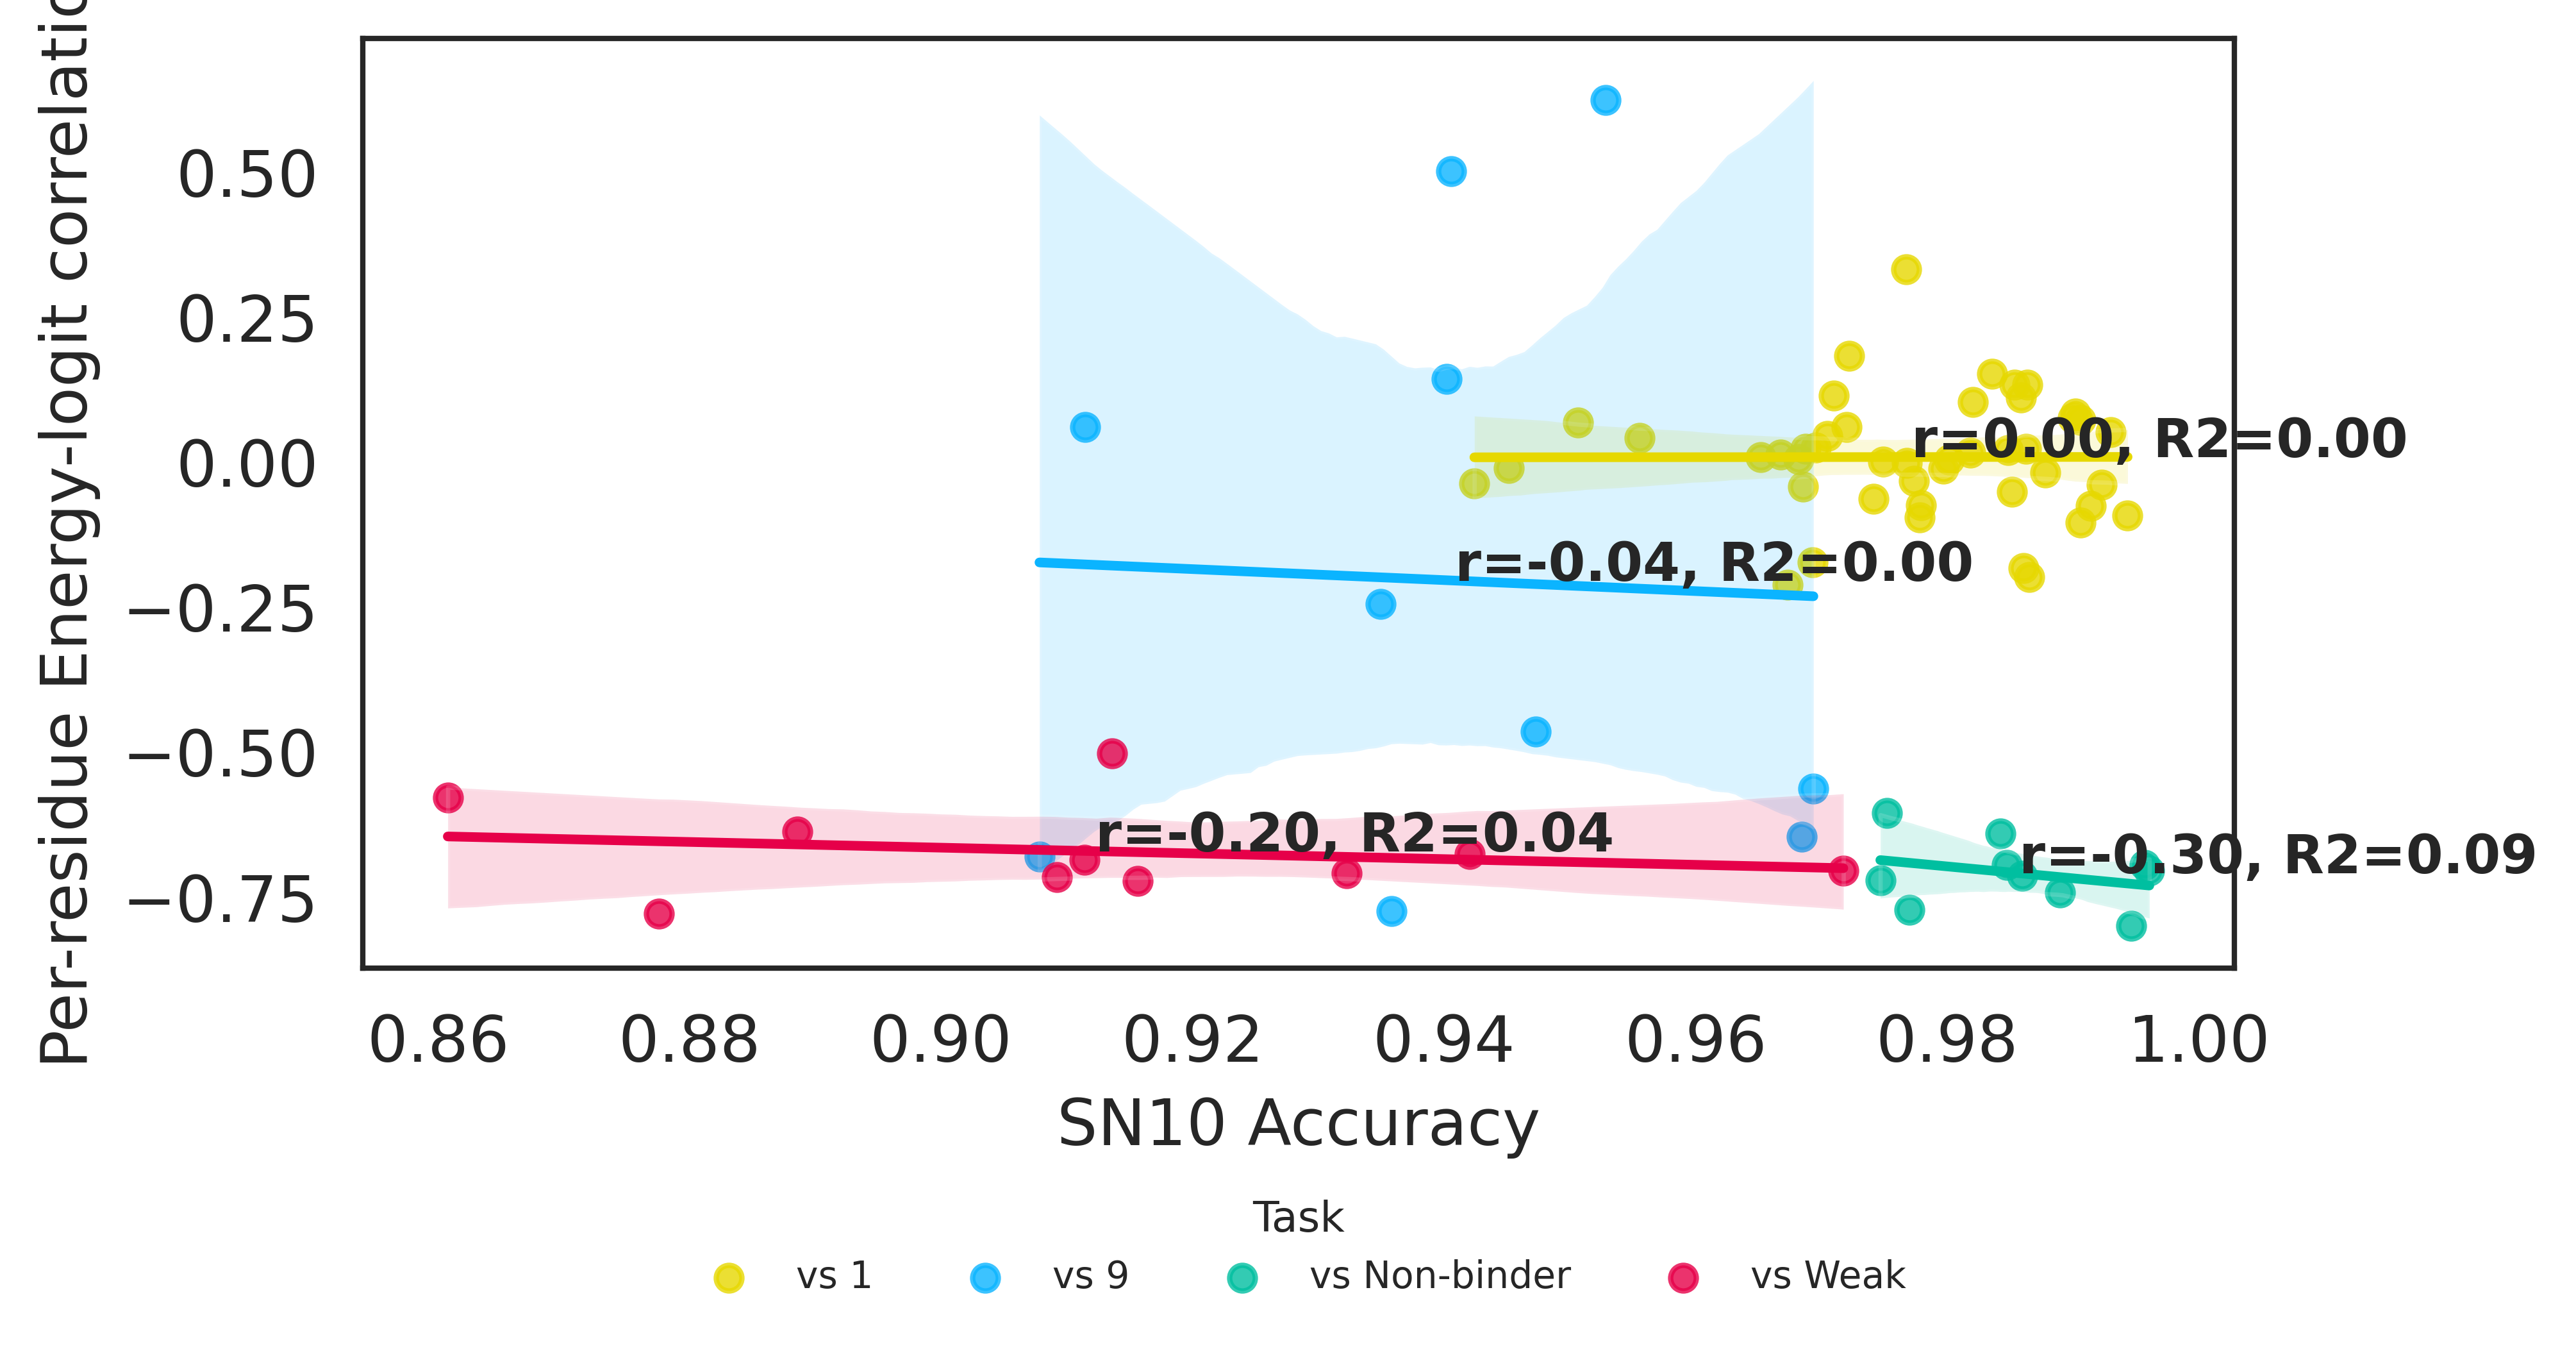

In [ ]:
from scipy.stats import pearsonr

cmap = visualisations.PlotParams.cmap_tasks

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)

# Map to tasks clean
df_contributions_merged["task_type_clean"] = df_contributions_merged["task_type"].map(visualisations.PlotParams.map_task_type_to_clean)

# Line plot in seaborn with R2 regression
for i, df_g in df_contributions_merged.groupby("task_type_clean"):
    print(i)
    color = cmap[visualisations.PlotParams.order_tasks_clean.index(i)] # type: ignore
    sns.regplot(
        x="acc_closed",
        y="mean_pos_total",
        data=df_g,
        scatter=True,
        color=color,
        ax=ax,
        label=i,
    )

    # Compute Pearson correlation
    r, pval = pearsonr(df_g["mean_pos_total"], df_g["acc_closed"])
    # Add text with r and R2 at centroid
    y = df_g["mean_pos_total"].mean()
    x = df_g["acc_closed"].mean()
    ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f}", fontsize=10, fontweight="bold")

FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_ylabel("Per-residue Energy-logit correlation", fontsize=FONT_SIZE)
ax.set_xlabel("SN10 Accuracy", fontsize=FONT_SIZE)

# ax.set_yticks(yticks)

# Title
# ax.set_title("Relationship beteen SN10 accuracy and Jensen-Shannon Divergence (JSD)", fontsize=FONT_SIZE)

# fig.savefig("figures/1B.svg")
fig.show()

Plotting individual energy contributions correlations

In [ ]:
def plot_energy_contributions_per_task(task, slide_class = "positive", plot_perc = False, ax = None):
    _, slide_df = load_energy_contributions_from_task_nonlinear_version(task, load_slide_df=True)
    all_energies = []
    all_energies_perc = []
    all_attrs = []
    all_attrs_perc = []

    for i, row in slide_df.iterrows():
        if row["class"] != slide_class:
            continue
        energies = row["energies"]
        all_energies += energies
        all_energies_perc += (np.array(energies) / np.sum(energies)).tolist()

        attrs = row["attributions"]
        all_attrs += attrs.tolist()
        all_attrs_perc += (np.array(attrs) / np.sum(np.abs(attrs))).tolist()

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    if plot_perc:
        ax.plot(
            all_attrs_perc, 
            all_energies_perc, 
            'o', 
            alpha=0.1,
            color="#f1593a", # red
            )
    else:
        ax.plot(all_attrs, all_energies, 'o', alpha=0.1)

    # Compute correlation and add text

    r, p = pearsonr(all_energies_perc, all_attrs_perc)
    r2 = r ** 2
    ax.text(
        0.23,
        0.03,
        f"r = {r:.2f}\n$r^2$ = {r2:.2f}",
        bbox=dict(facecolor="white", alpha=0.5),
    )

In [ ]:
# task = datasets.ClassificationTask(
#     task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
#     ag_pos="5E94",
#     ag_neg="auto",
#     seed_id=0,
#     split_id=0,
# )

# fig, ax = plt.subplots(figsize=(10, 5))
# plot_energy_contributions_per_task(task, ax=ax)
# ax.set_title("Energy contributions vs attributions for (5E94 vs 9)")

In [ ]:
sns.scatterplot(
    data=df,
    x="Energy",
    y="logits",
    hue="class",
    ax=ax,
    palette=cmap,
)

/tmp/ipykernel_1363179/3403770409.py:1: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(


<AxesSubplot: xlabel='Task', ylabel='Pearson correlation coefficient'>

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Text(0.5, 0, 'Attribution (signed fraction)')

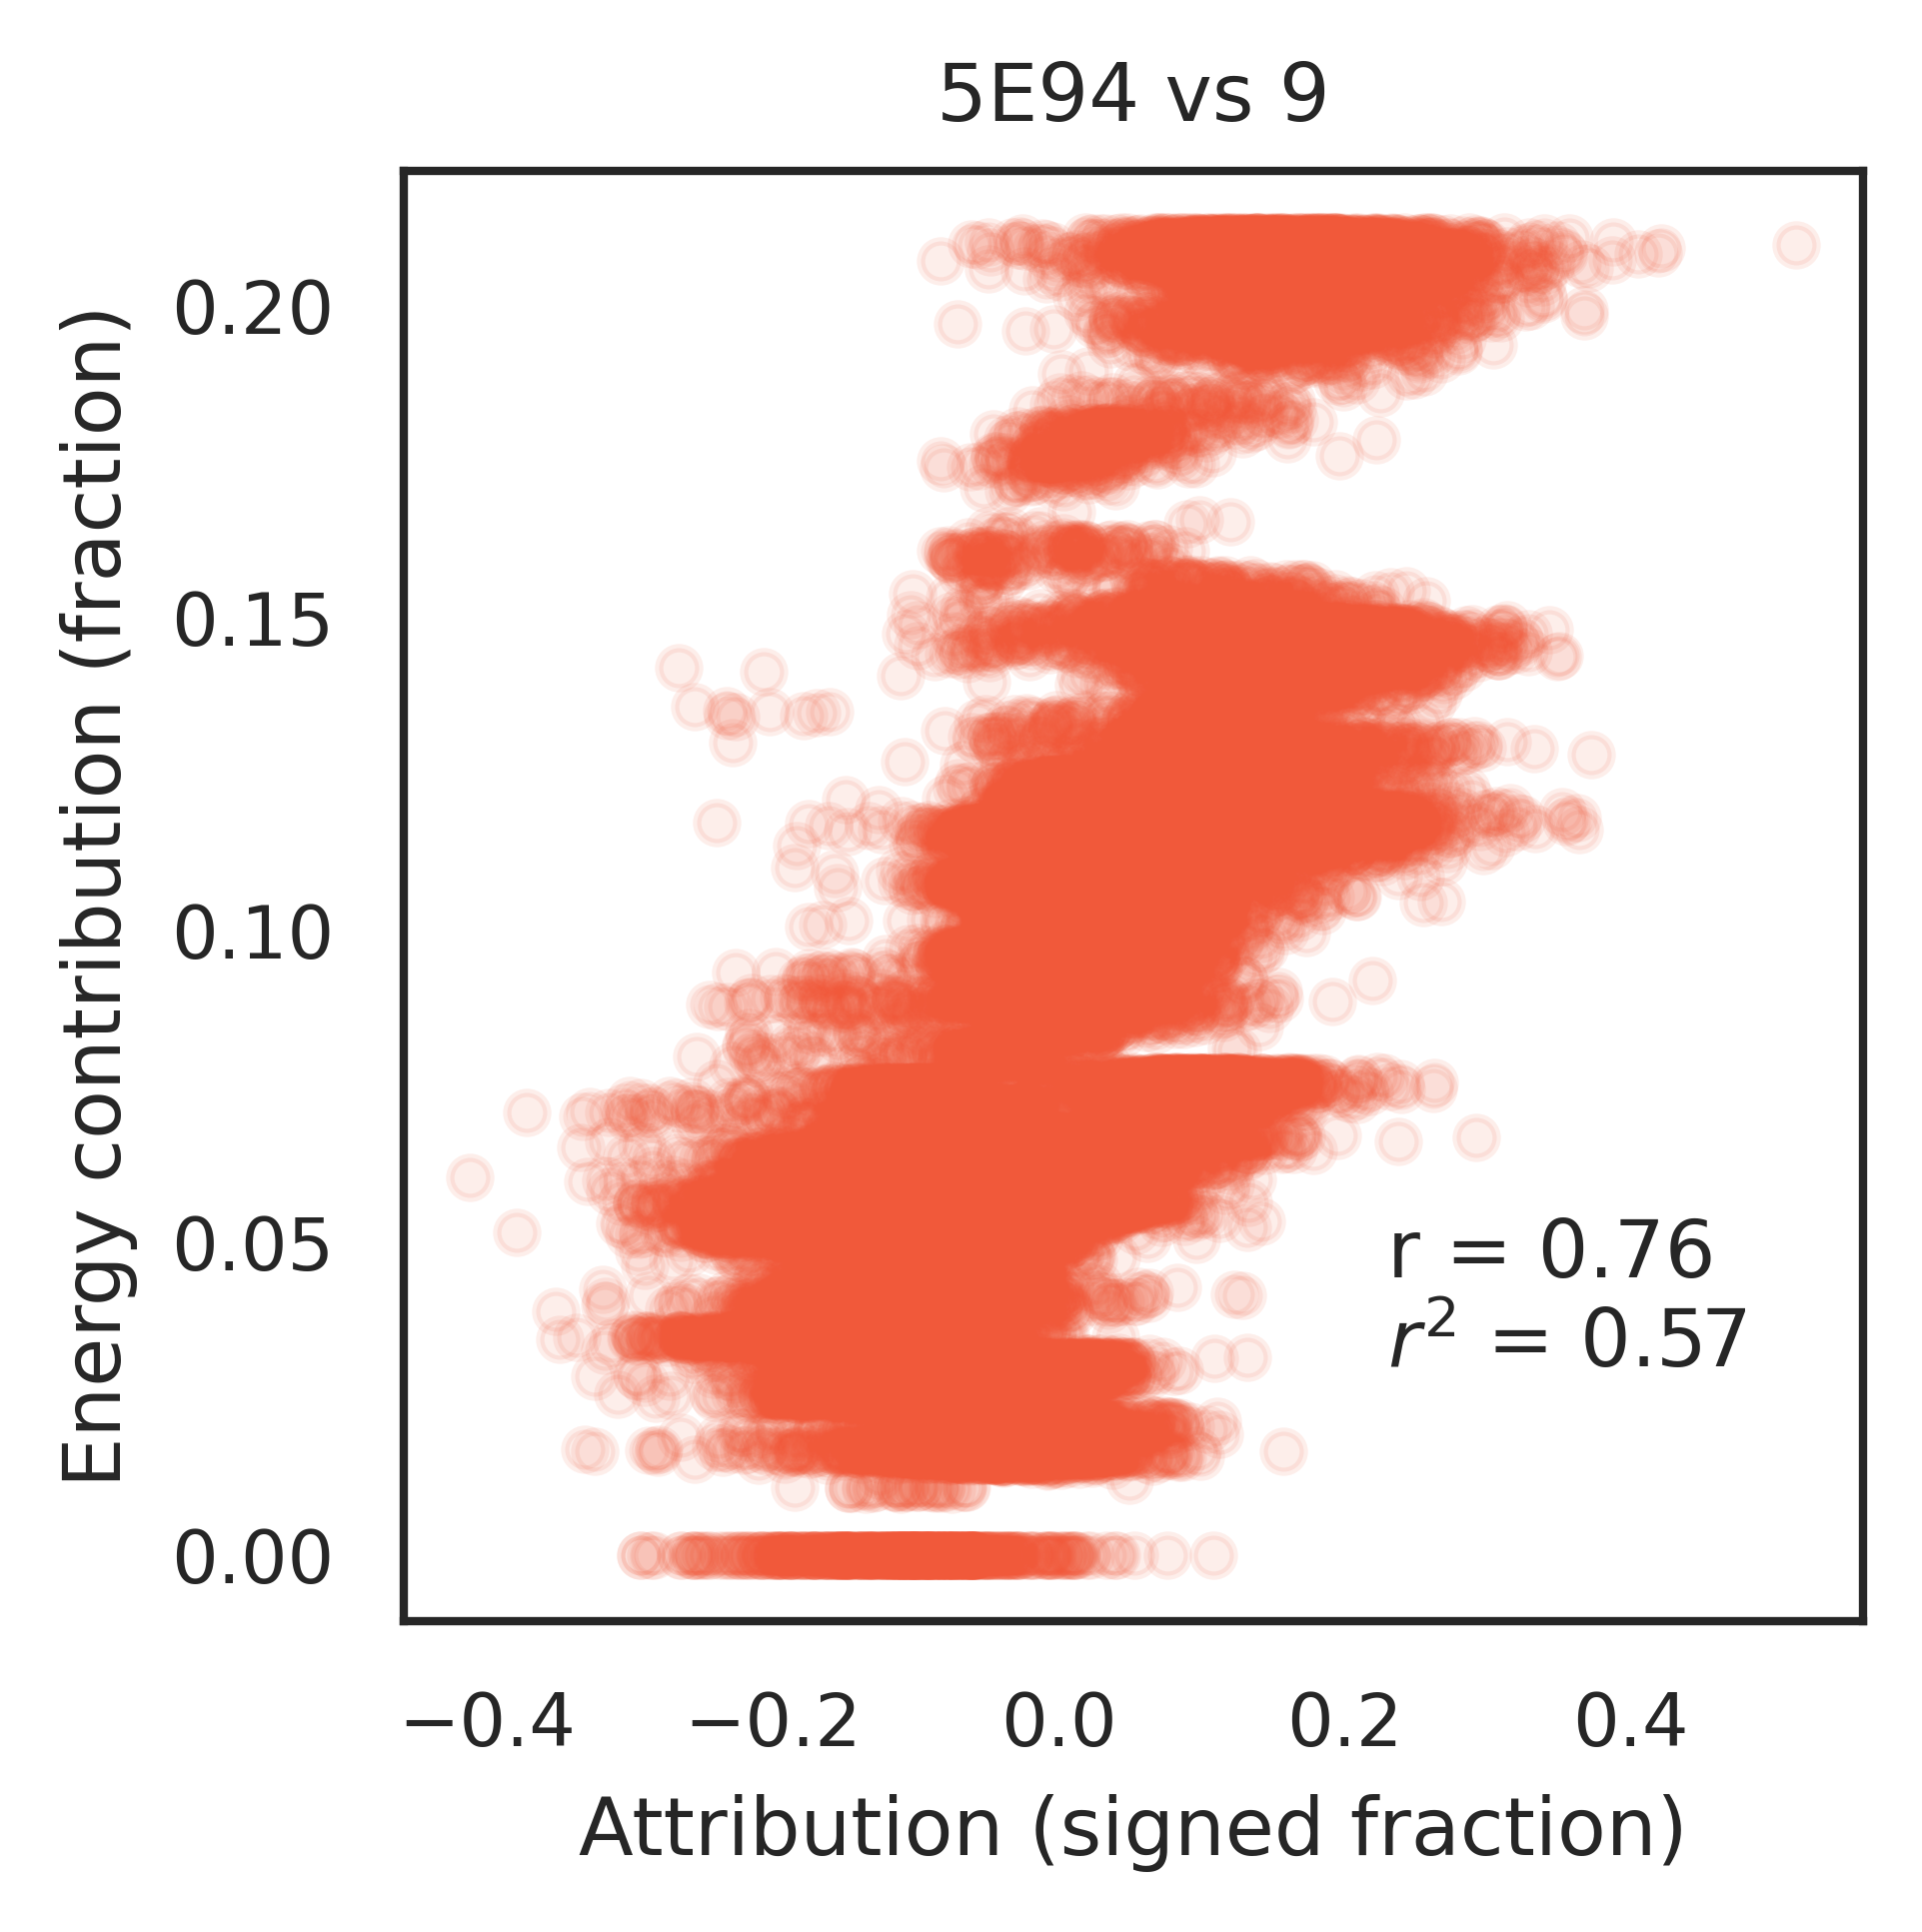

In [ ]:
task = datasets.ClassificationTask(
    task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
    ag_pos="5E94",
    ag_neg="auto",
    seed_id=0,
    split_id=0,
)

fig, ax = plt.subplots(figsize=(3.14, 3.14), dpi=600)
sns.set_theme(context="paper")
sns.set_style("white")

cmap = ["#f1593a"]  # red

plot_energy_contributions_per_task(task, plot_perc=True, ax=ax)
ax.set_title("5E94 vs 9")
ax.set_ylabel("Energy contribution (fraction)")
ax.set_xlabel("Attribution (signed fraction)")

In [ ]:
# task = datasets.ClassificationTask(
#     task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
#     ag_pos="1NSN",
#     ag_neg="auto",
#     seed_id=0,
#     split_id=0,
# )

# fig, ax = plt.subplots(figsize=(10, 5))
# plot_energy_contributions_per_task(task, plot_perc=True, ax=ax)
# ax.set_title("Energy contributions vs attributions for (1NSN vs 9)")
# ax.set_ylabel("Energy contribution (%)")
# ax.set_xlabel("Attribution (signed %)")

In [ ]:
# task = datasets.ClassificationTask(
#     task_type=datasets.ClassificationTaskType.HIGH_VS_LOOSER,
#     ag_pos="5E94",
#     ag_neg="auto",
#     seed_id=0,
#     split_id=0,
# )

# fig, ax = plt.subplots(figsize=(10, 5))
# plot_energy_contributions_per_task(task, plot_perc=True, ax=ax)
# ax.set_title("Energy contributions vs attributions for (5E94 high vs looser)")
# ax.set_ylabel("Energy contribution (%)")
# ax.set_xlabel("Attribution (signed %)")

In [ ]:
# task = datasets.ClassificationTask(
#     task_type=datasets.ClassificationTaskType.HIGH_VS_LOOSER,
#     ag_pos="1NSN",
#     ag_neg="auto",
#     seed_id=0,
#     split_id=0,
# )

# fig, ax = plt.subplots(figsize=(10, 5))
# plot_energy_contributions_per_task(task, plot_perc=True, ax=ax)
# ax.set_title("Energy contributions vs attributions for (1NSN high vs looser)")
# ax.set_ylabel("Energy contribution (%)")
# ax.set_xlabel("Attribution (signed %)")

Error analysis on AA Contributions

In [ ]:
task = datasets.ClassificationTask(
    task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
    ag_pos="5E94",
    ag_neg="auto",
    seed_id=0,
    split_id=42,
)
_, slide_df = load_energy_contributions_from_task_nonlinear_version(task, load_slide_df=True)

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


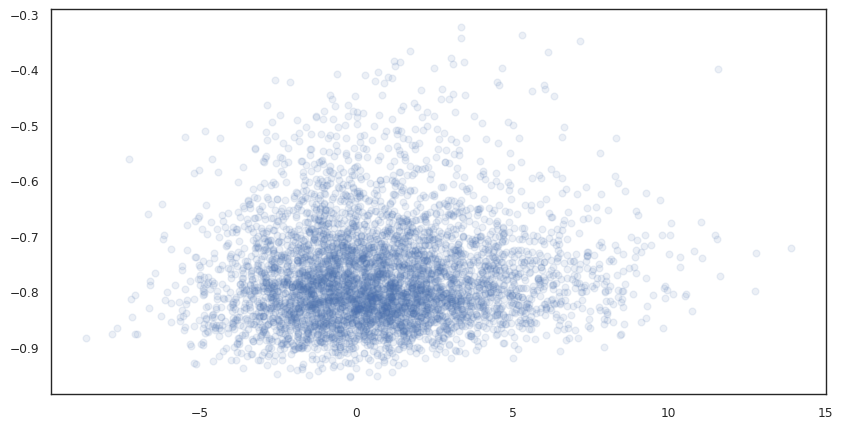

In [ ]:
slide_df["attributions_sum"] = slide_df["attributions"].apply(lambda x: np.sum(x))

# Plot r_total vs attributions_sum
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(slide_df["attributions_sum"], slide_df["r_total"], 'o', alpha=0.1)

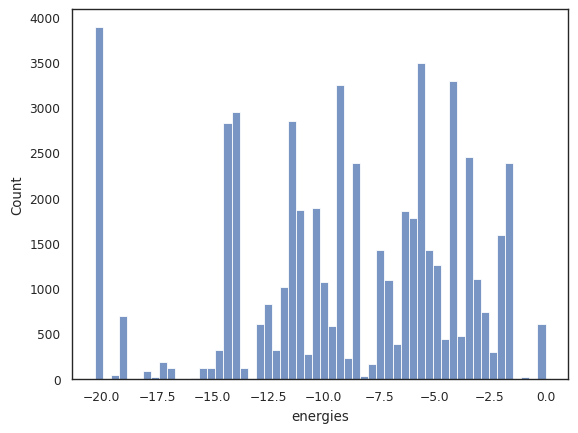

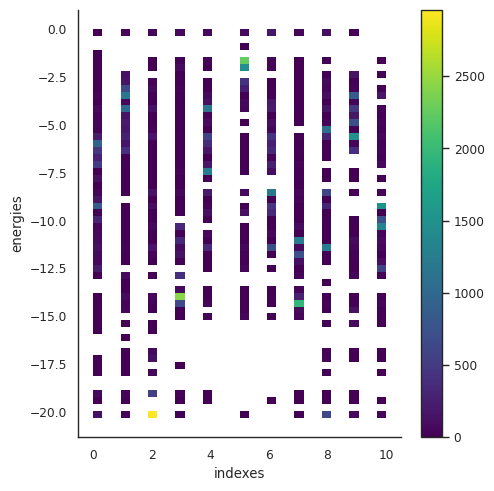

In [ ]:
# Collect all energies with indexes in list from slide_df and plot distribution
energies = []
indexes = []
for i, row in slide_df.iterrows():
    energies_i = row["energies"]
    energies += energies_i
    indexes_i = list(range(0, 11))
    indexes += indexes_i

sns.histplot(
    data=pd.DataFrame({"energies": energies, "indexes": indexes}),
    x="energies",
)

sns.displot(
    data=pd.DataFrame({"energies": energies, "indexes": indexes}),
    x="indexes",
    y="energies",
    cmap="viridis",
    rug=False,
    cbar=True,
)

In [ ]:
task = datasets.ClassificationTask(
    task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
    ag_pos="1NSN",
    ag_neg="auto",
    seed_id=0,
    split_id=42,
)
_, slide_df = load_energy_contributions_from_task_nonlinear_version(task, load_slide_df=True)

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


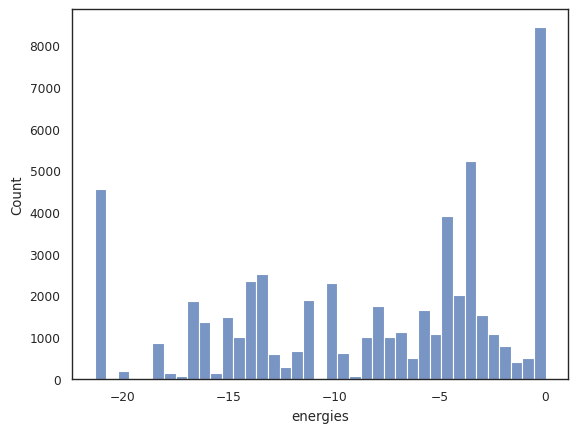

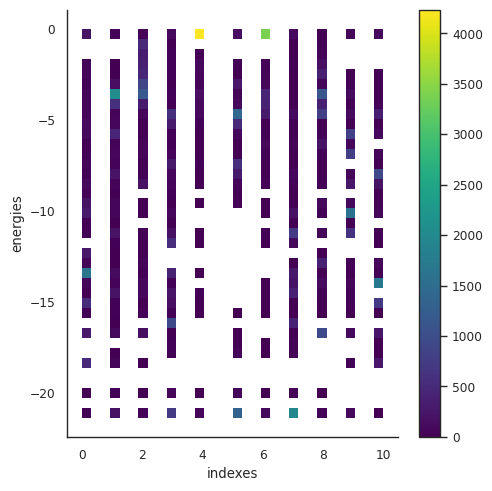

In [ ]:
# Collect all energies with indexes in list from slide_df and plot distribution
energies = []
indexes = []
for i, row in slide_df.iterrows():
    energies_i = row["energies"]
    energies += energies_i
    indexes_i = list(range(0, 11))
    indexes += indexes_i

sns.histplot(
    data=pd.DataFrame({"energies": energies, "indexes": indexes}),
    x="energies",
)

sns.displot(
    data=pd.DataFrame({"energies": energies, "indexes": indexes}),
    x="indexes",
    y="energies",
    cmap="viridis",
    rug=False,
    cbar=True,
)

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scip

FileNotFoundError: [Errno 2] No such file or directory: '../data/MiniAbsolut/1ADQ/energy_contributions/high_test_5000_absolut_energy_contributions.tsv'

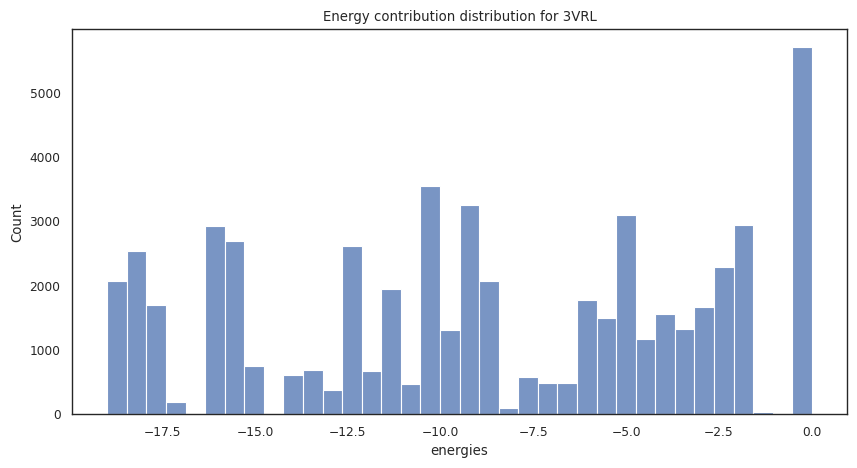

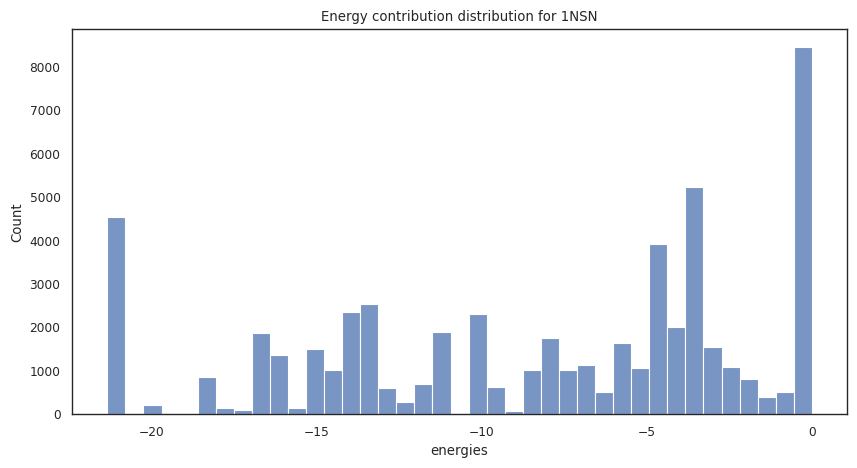

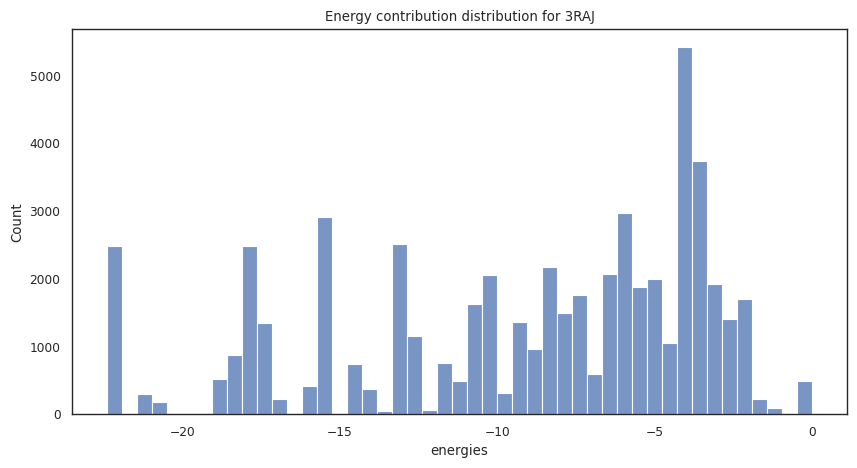

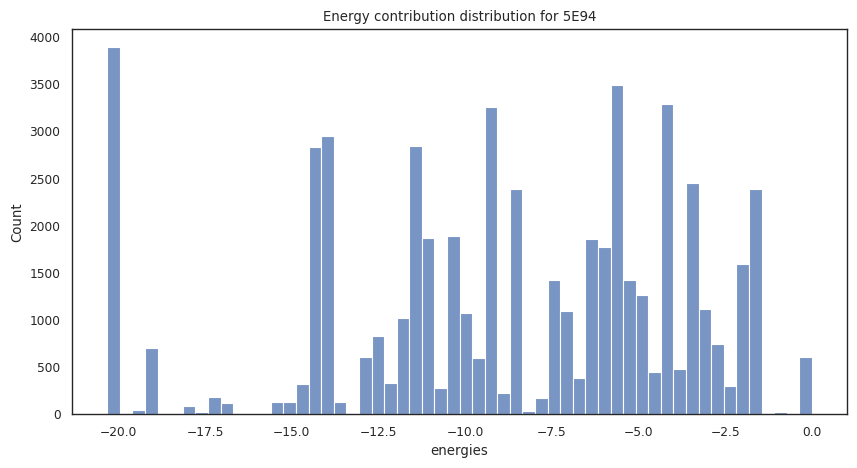

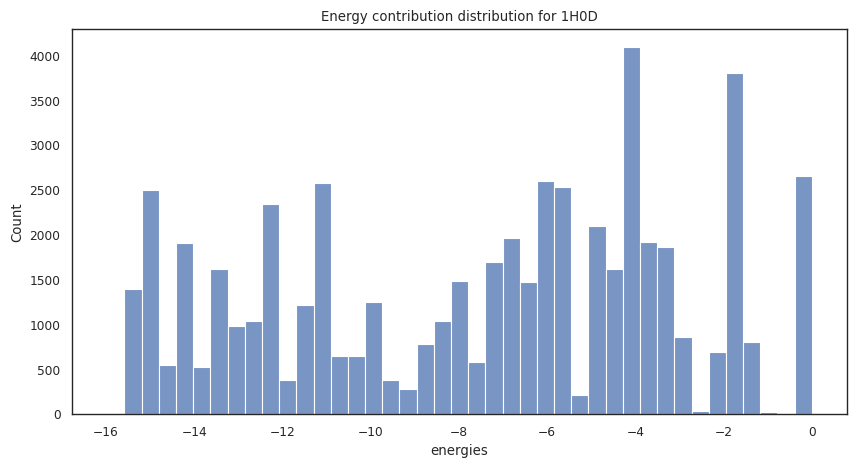

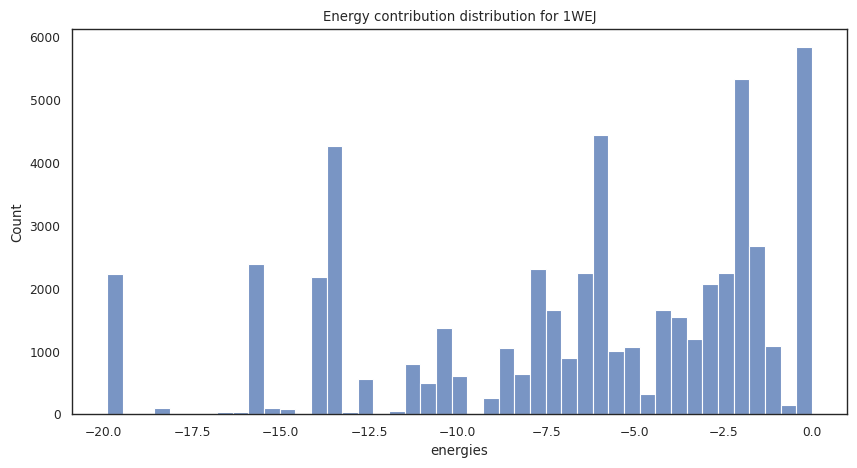

In [ ]:
for ag in config.ANTIGENS:
    task = datasets.ClassificationTask(
        task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
        ag_pos=ag,
        ag_neg="auto",
        seed_id=0,
        split_id=42,
    )
    _, slide_df = load_energy_contributions_from_task_nonlinear_version(task, load_slide_df=True)
    
    energies = []
    indexes = []
    for i, row in slide_df.iterrows():
        energies_i = row["energies"]
        energies += energies_i
        indexes_i = list(range(0, 11))
        indexes += indexes_i

    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(
        data=pd.DataFrame({"energies": energies, "indexes": indexes}),
        x="energies",
    )
    ax.set_title(f"Energy contribution distribution for {ag}")